# Distributed Training Guidebook with Horovod and TensorFlow

Authors: LZY, DC, LXB

In this notebook, we will show how to do distributed training on Google Cloud Platform with horovod step by step.

# **Content**

## TensorFlow

### I. Configure the Environment
### II. Get Dataset and Model
### III. Run Python Script Simutaneously

## Horovod

### I. Set Up Training Environment on Google Cloud Platform
####     1. Create VMs and install HOROVOD
####     2. Set up a passwordless SSH login
####     3. Create firewall rules

### II. Write a Training Script in Horovod Style

### III. Define a Customized Compression Technique: QSGD

## Appendix

#### 1.SetupScriptforTensorFlow.py
#### 2.TensorFlowTrainingScript.py
#### 3.HorovodTrainingScript.py
#### 4.CompressionTechnique.py
---

## TensorFlow

### I. Configure the Environment
### II. Get Dataset and Model
### III. Run Python Script Simutaneously

### I. Configure the Environment
It is __IMPORTANT__ to configure the enironment and instantiate the strategy at the start of the programme. Otherwise, you may encounter the error "RuntimeError: Collective ops must be configured at program startup".

#### Configure the Environment and Instantiate the Strategy

#### Key Step: Add the IP Addresses to the Environment
This step is to tell the computers in the cluster who they are working with.
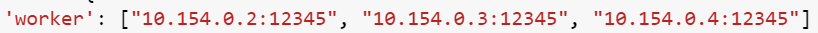
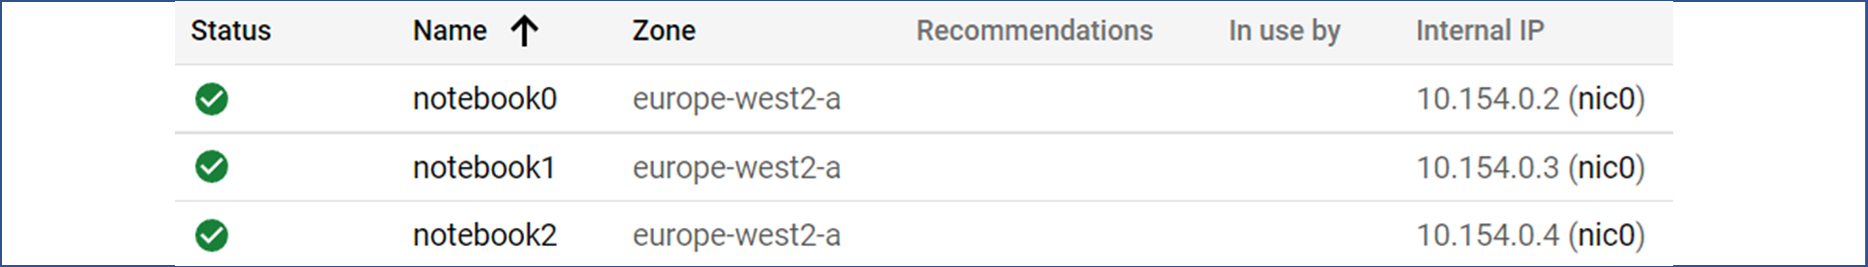

__DO CHANGING THE NUMBER OF INDEX!__  

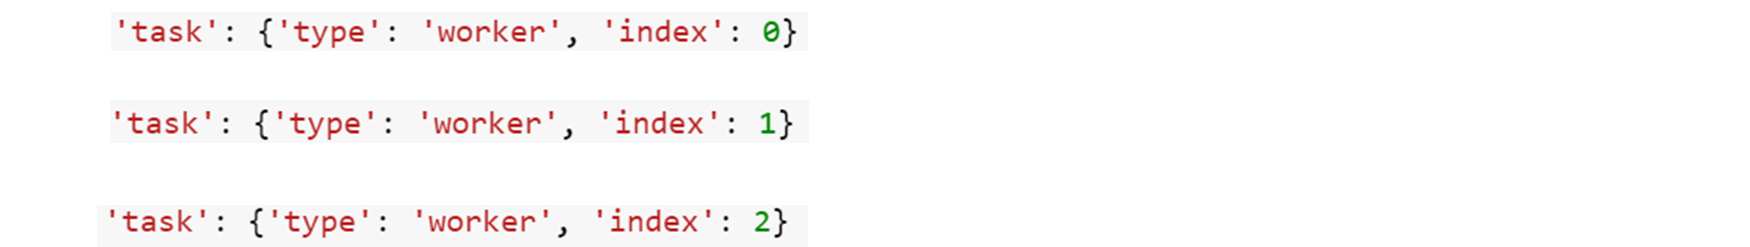   
notebook0:`'task': {'type': 'worker', 'index': 0}`   
notebook1:`'task': {'type': 'worker', 'index': 1}`   
notebook2:`'task': {'type': 'worker', 'index': 2}`   
If there are 4 computers in the cluster, the index should be 0,1,2,3. Otherwise, you task would be stuck though you would not receive any programme error.

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ.pop('TF_CONFIG', None)

if '.' not in sys.path:
    sys.path.insert(0, '.')

os.environ["TF_CONFIG"] = json.dumps({
    'cluster': {
        'worker': ["10.154.0.2:12345", "10.154.0.3:12345", "10.154.0.4:12345"]
    },
    'task': {'type': 'worker', 'index': 0}
})

strategy = tf.distribute.MultiWorkerMirroredStrategy()

### II. Get Dataset and Model
We assume you know how to build up a DNN model, so we just simply demostrate the dataset and model we used for experiments here withou much explanation.    
The codes defining dataset and model below are originally from https://keras.io/zh/examples/cifar10_resnet/.

#### Dataset

In [ ]:
def cifar10_dataset(batch):
    # Load the CIFAR10 data.
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Input image dimensions.
    input_shape = x_train.shape[1:]

    # Normalize data.
    x_train = x_train.astype('float32') / 255

    # If subtract pixel mean is enabled

    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean

    # Convert class vectors to binary class matrices.
    y_train = tf.keras.utils.to_categorical(y_train, 10)

    dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_train[..., tf.newaxis], tf.float32),
                                      tf.cast(y_train, tf.int64))
    )

    dataset = dataset.repeat().shuffle(10000).batch(batch)
    return dataset

#### ResNet Model

In [ ]:
def build_and_compile_ResNet_model():
    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation='relu',
                     batch_normalization=True,
                     conv_first=True):

        conv = Conv2D(num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=l2(1e-4))

        x = inputs
        if conv_first:
            x = conv(x)
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
        else:
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
            x = conv(x)
        return x

    def resnet_v1(input_shape, depth = 44, num_classes=10):
        if (depth - 2) % 6 != 0:
            raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
        # Start model definition.
        num_filters = 16
        num_res_blocks = int((depth - 2) / 6)

        inputs = Input(shape=input_shape)
        x = resnet_layer(inputs=inputs)
        # Instantiate the stack of residual units
        for stack in range(3):
            for res_block in range(num_res_blocks):
                strides = 1
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides = 2  # downsample
                y = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 strides=strides)
                y = resnet_layer(inputs=y,
                                 num_filters=num_filters,
                                 activation=None)
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x = resnet_layer(inputs=x,
                                     num_filters=num_filters,
                                     kernel_size=1,
                                     strides=strides,
                                     activation=None,
                                     batch_normalization=False)
                x = keras.layers.add([x, y])
                x = Activation('relu')(x)
            num_filters *= 2

        # Add classifier on top.
        # v1 does not use BN after last shortcut connection-ReLU
        x = AveragePooling2D(pool_size=8)(x)
        y = Flatten()(x)
        outputs = Dense(num_classes,
                        activation='softmax',
                        kernel_initializer='he_normal')(y)

        # Instantiate model.
        model = Model(inputs=inputs, outputs=outputs)
        
        return model
    
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    input_shape = x_train.shape[1:]
    
    model = resnet_v1(input_shape=input_shape, depth=44)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.optimizers.Adam(0.001),
                  metrics=['accuracy'])
    return model

In [ ]:
per_worker_batch_size = 128
tf_config = json.loads(os.environ['TF_CONFIG'])
num_workers = len(tf_config['cluster']['worker'])


global_batch_size = per_worker_batch_size * num_workers
multi_worker_dataset = SetupScriptforTensorFlow.cifar10_dataset(global_batch_size)

#### !!! IMPORTANT STEP
__Model building/compiling need to be within `strategy.scope()`.__

In [ ]:
with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
    multi_worker_model = SetupScriptforTensorFlow.build_and_compile_ResNet_model()

#### Fit the Model

In [ ]:
multi_worker_model.fit(multi_worker_dataset, epochs=20, steps_per_epoch=200 // num_workers )

#### Upload Files
Notebook0: `'task': {'type': 'worker', 'index': 0}`  
Notebook1: `'task': {'type': 'worker', 'index': 1}`  
Notebook2: `'task': {'type': 'worker', 'index': 2}`  
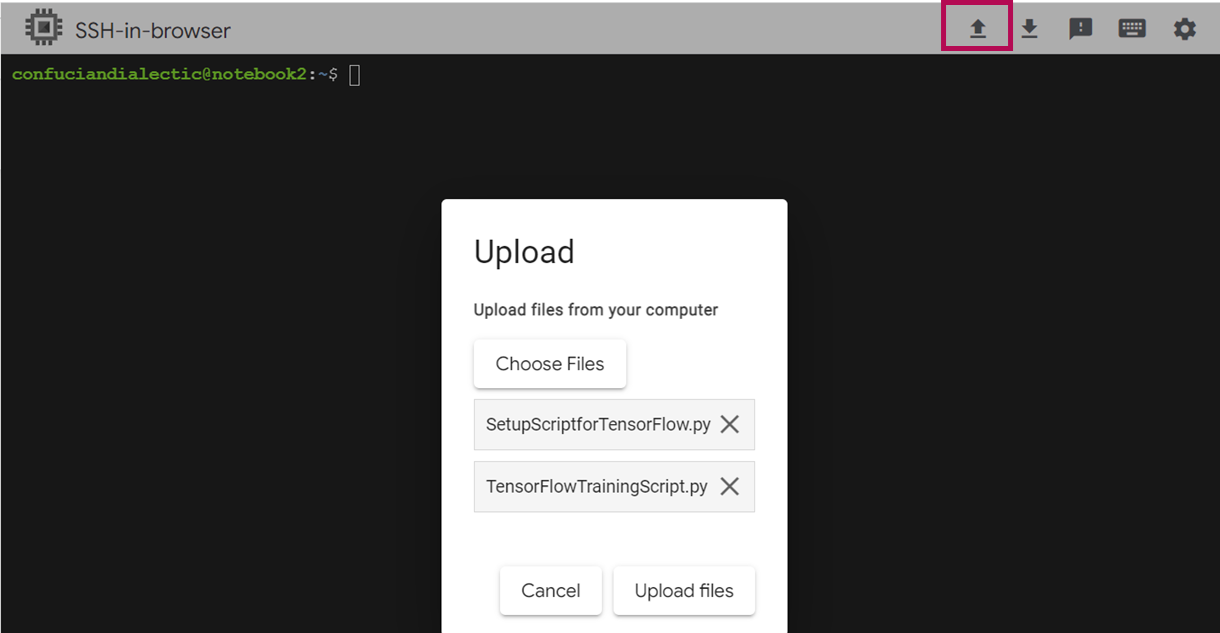

### III.Run Python Script Simutaneously
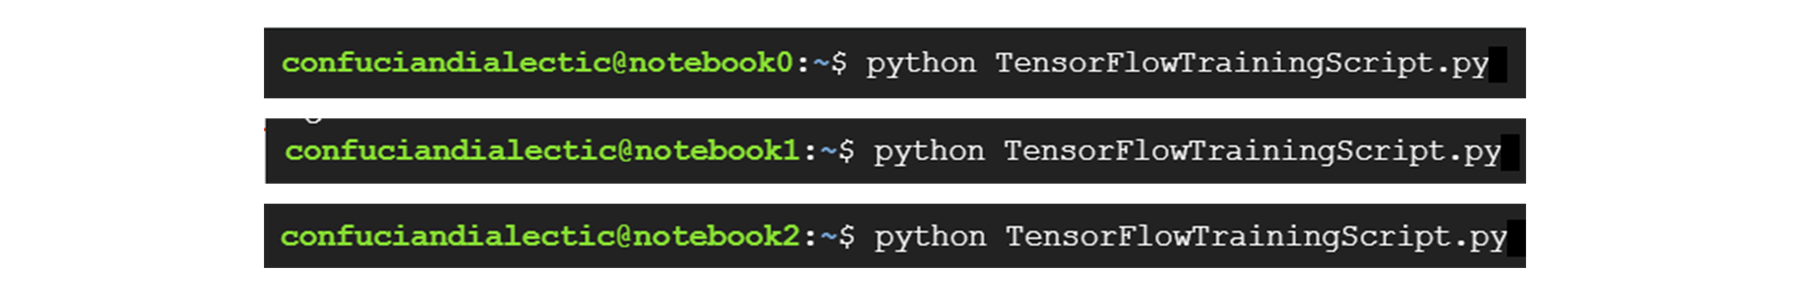
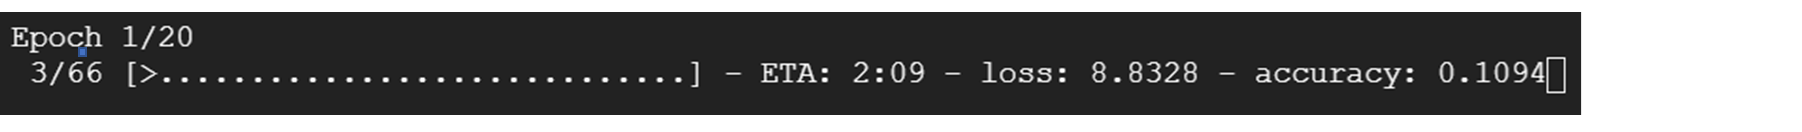

## Horovod

### I. Set Up Training Environment on Google Cloud Platform
####     1. Create VMs and install HOROVOD
####     2. Set up a passwordless SSH login
####     3. Create firewall rules

### II. Write a Training Script in Horovod Style

### III. Define a Customized Compression Technique: QSGD

### I. Set Up Training Environment on Google Cloud Platform

### **1. Create VMs and install HOROVOD**

#### **1.1. Create NOTEBOOK in Workbench**
Note: TensorFlow 2.2 or above is recommended as some compression technique may requires eager execution.

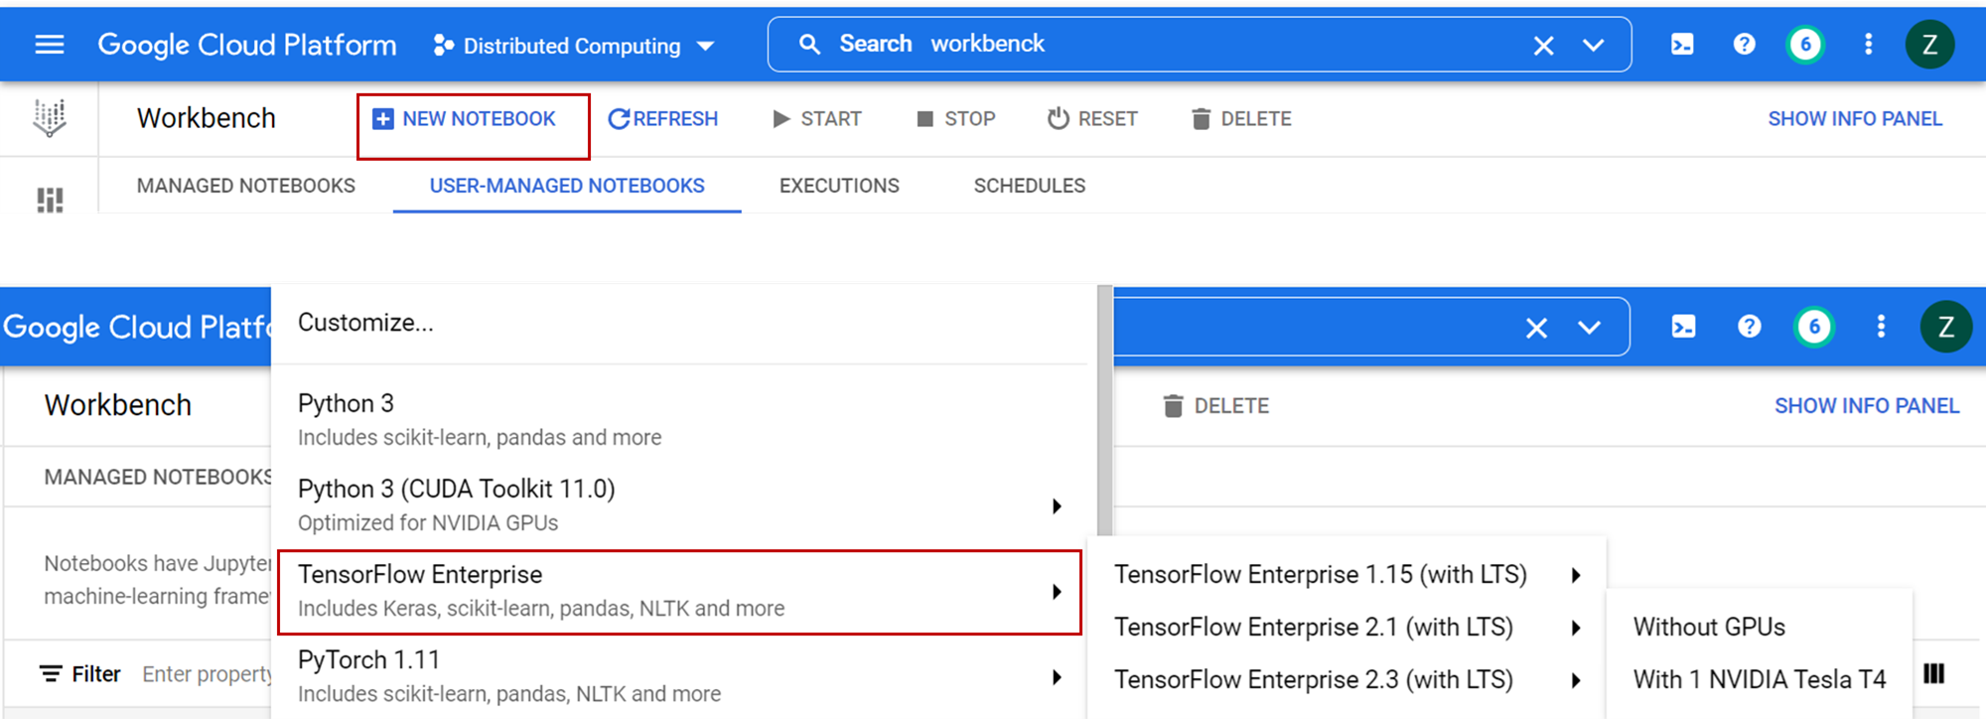

In [3]:
Image(filename='ST446/1.1.png', width=1200)

#### **1.2. Click on ADVANCED OPTIONS in the lower left corner**

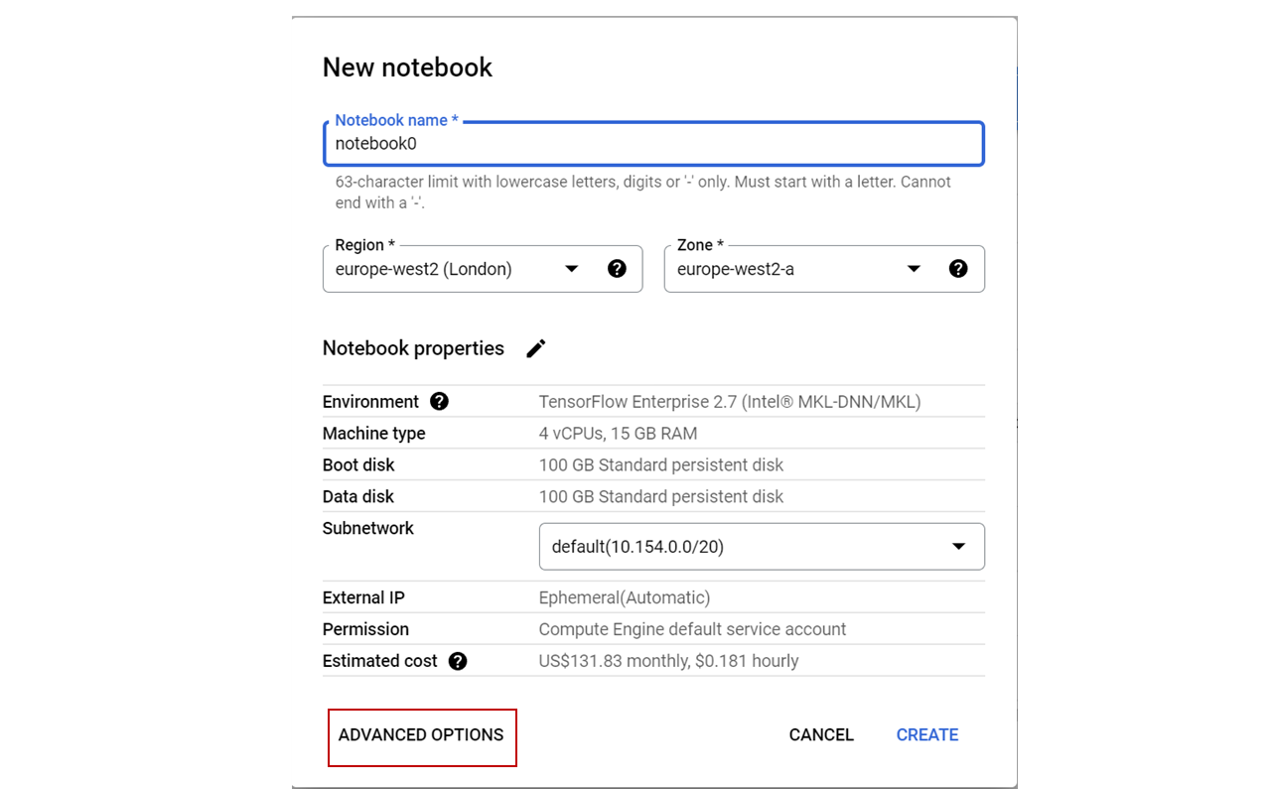

In [4]:
Image(filename='ST446/1.2.png', width=1200)

#### **1.3. [Key step!] Upload the Startup file**
my_actions.sh   

`#! /bin/bash
python -m pip install --no-cache-dir horovod[tensorflow,keras,spark]
python -m pip install tensorflow
python -m pip install --upgrade pip`


The file can first be uploaded to the bucket. Uploading the Startup file is a crucial step.  

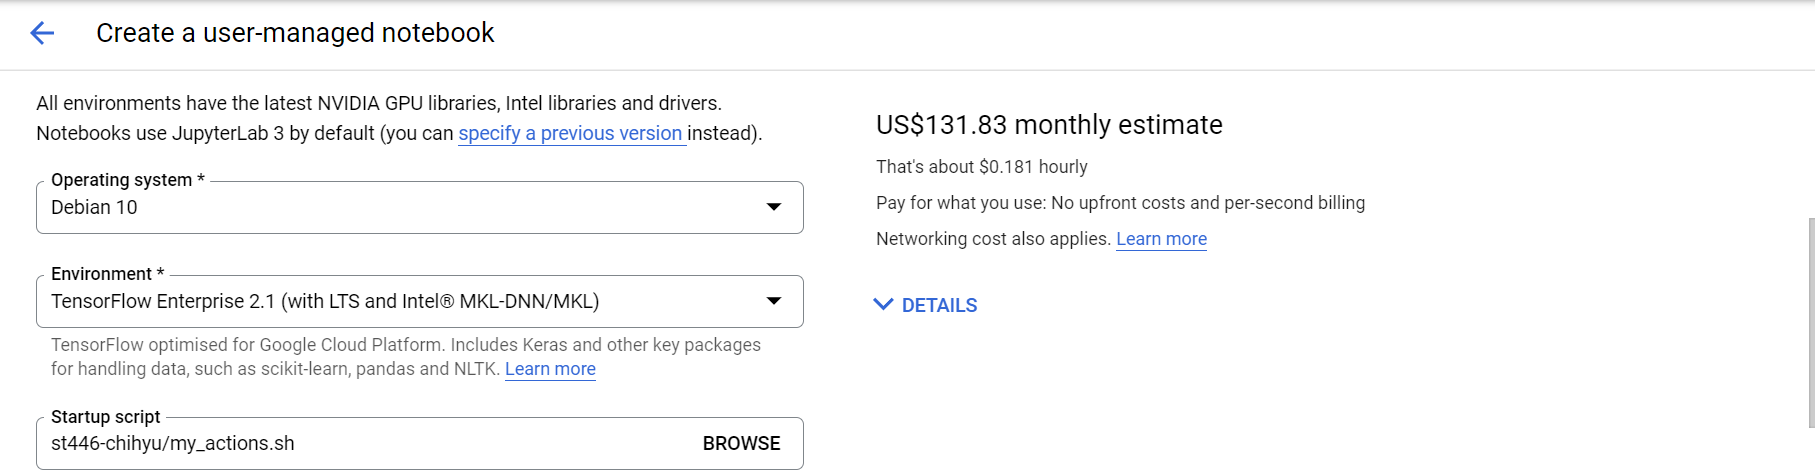

In [37]:
Image(filename='ST446/1.3.png', width=1200)

#### **1.4.After creating the notebook, go to the VM instances interface, click SSH, and execute the following code in the terminal:**

`pip uninstall horovod`   
`pip install --no-cache-dir horovod` 
(May take about 5-10 minutes to run this line of code.)


Reminder: This step can be performed on multiple VMs at the same time to save time

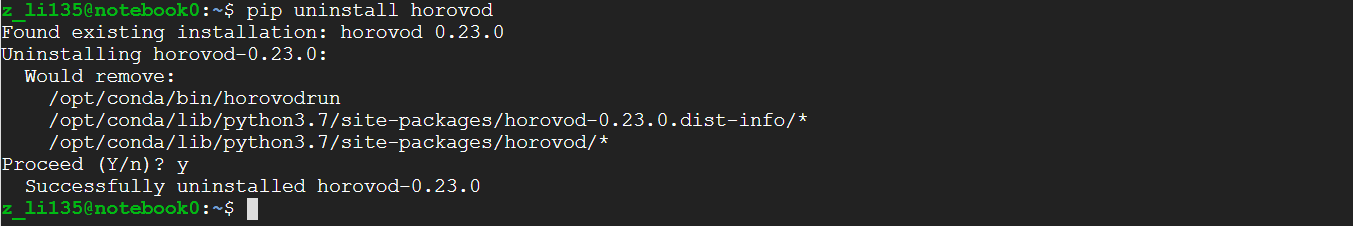

In [38]:
Image(filename='ST446/1.41.png', width=1200)

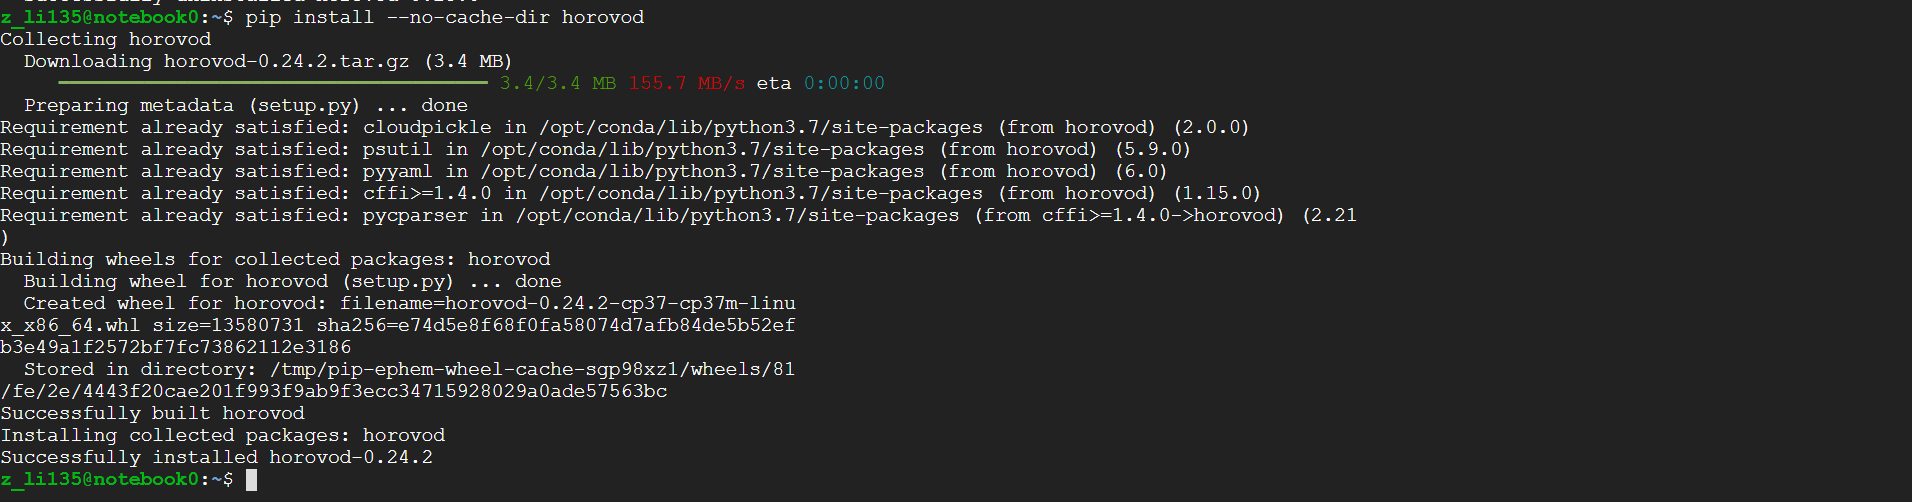

In [39]:
Image(filename='ST446/1.42.png', width=1200)

#### The horovod installation is complete after doing the steps above. It can be verified with the following code:

`import horovod.tensorflow as hvd`

If the code runs successfully, it proves that horovod has been successfully installed.

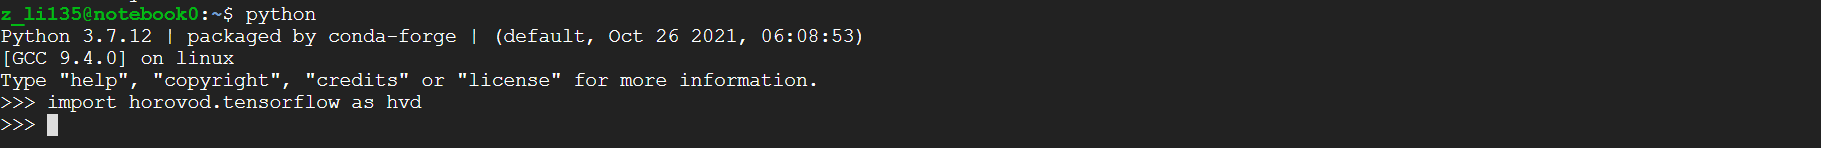

In [40]:
Image(filename='ST446/1.43.png', width=1200)

### Then we start to set up a passwordless SSH login

### 2. Set up a passwordless SSH login

#### **Status Quo：**


1）When connecting the notebook to itself, a successful connection is established. For example, connect notebook0 to notebook0：


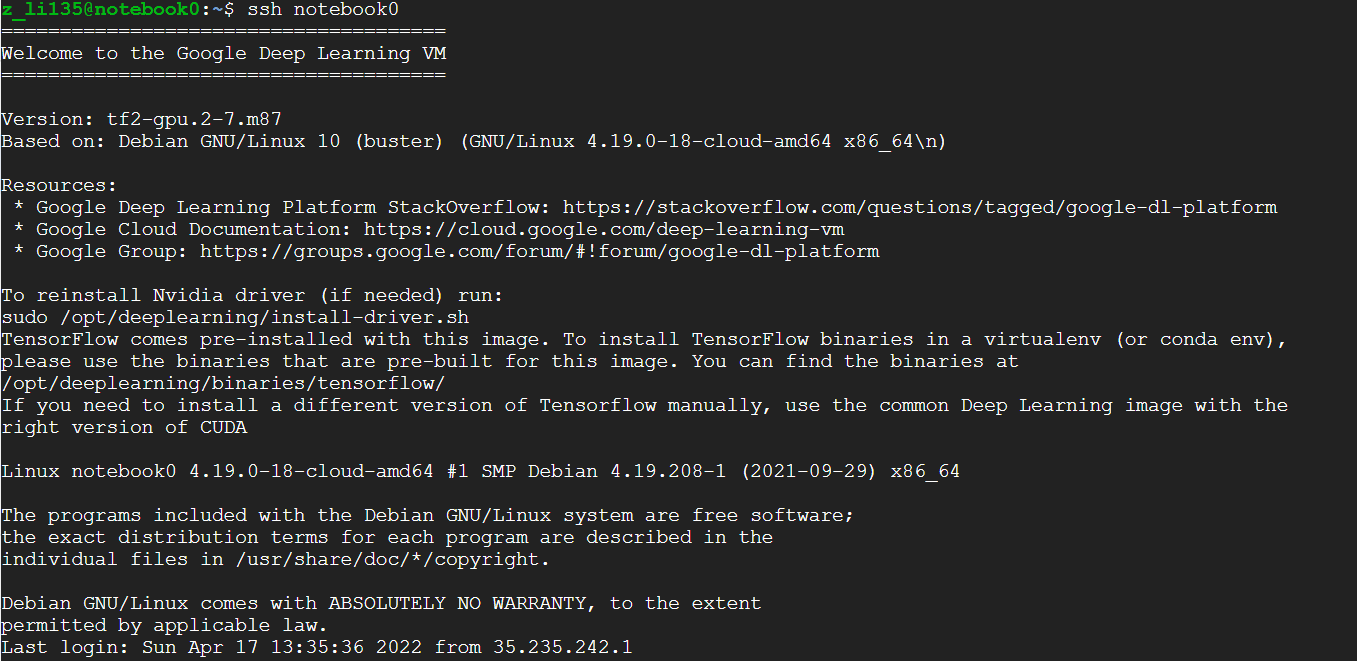

In [41]:
Image(filename='ST446/2.01.png', width=1200)

2）A connection to another VM, such as connecting notebook0 to notebook1 in notebook0 ternimal, fails since notebook0 does not have the public key for notebook1：

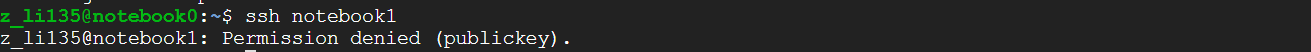

In [42]:
Image(filename='ST446/2.02.png', width=1200)

### **Steps to set up a passwordless SSH login:**

#### **2.1. Let notebook0 to generate a public key**

In terminal, enter the following code:

`ssh-keygen -t rsa -f ~/.ssh/{id_rsa} -C {z_li135} -b 2048` 

The contents of the curly brackets {} should be customized to the actual situation.

The first curly bracket {id_rsa} is the name of the file where the public key is stored, and can be filled in at random.

Second curly brace {z_li135} is the username, (you need to fill in your own username), where "z_li135" is my username.

Click ENTER to skip when asked to fill in the passphrase later.

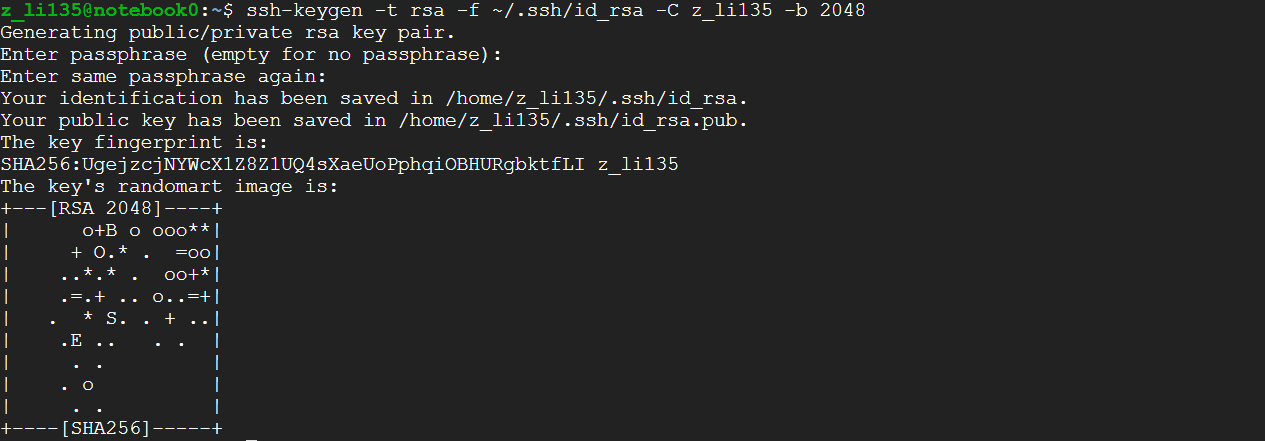

In [43]:
Image(filename='ST446/2.1.png', width=1200)

#### **2.2. Read the generated public key.**

In terminal, enter the following code:

`cat .ssh/id_rsa.pub`   

As the public key is named id_rsa above, fill in id_rsa.pub when reading it.

Step 1 specified that the public key should be stored under ~/.ssh/{id_rsa}, so just enter this path directly. 

A command like `ls -al {dir}` can help you search for the public key manually in case the path is not found.

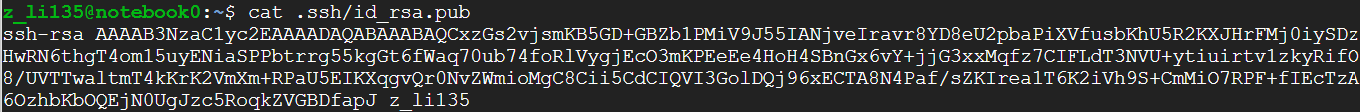

In [44]:
Image(filename='ST446/2.2.png', width=1200)

#### **2.3. Copy the key**
In this example the public key is: 

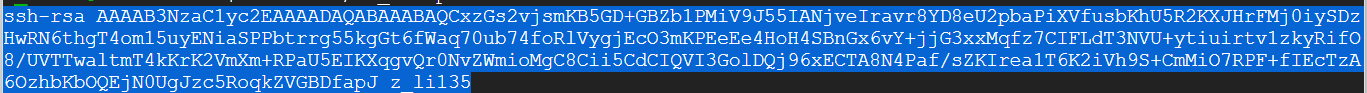

In [45]:
Image(filename='ST446/2.3.png', width=1200)

#### **2.4. Click Metadata in the sidebar to edit Metadata**

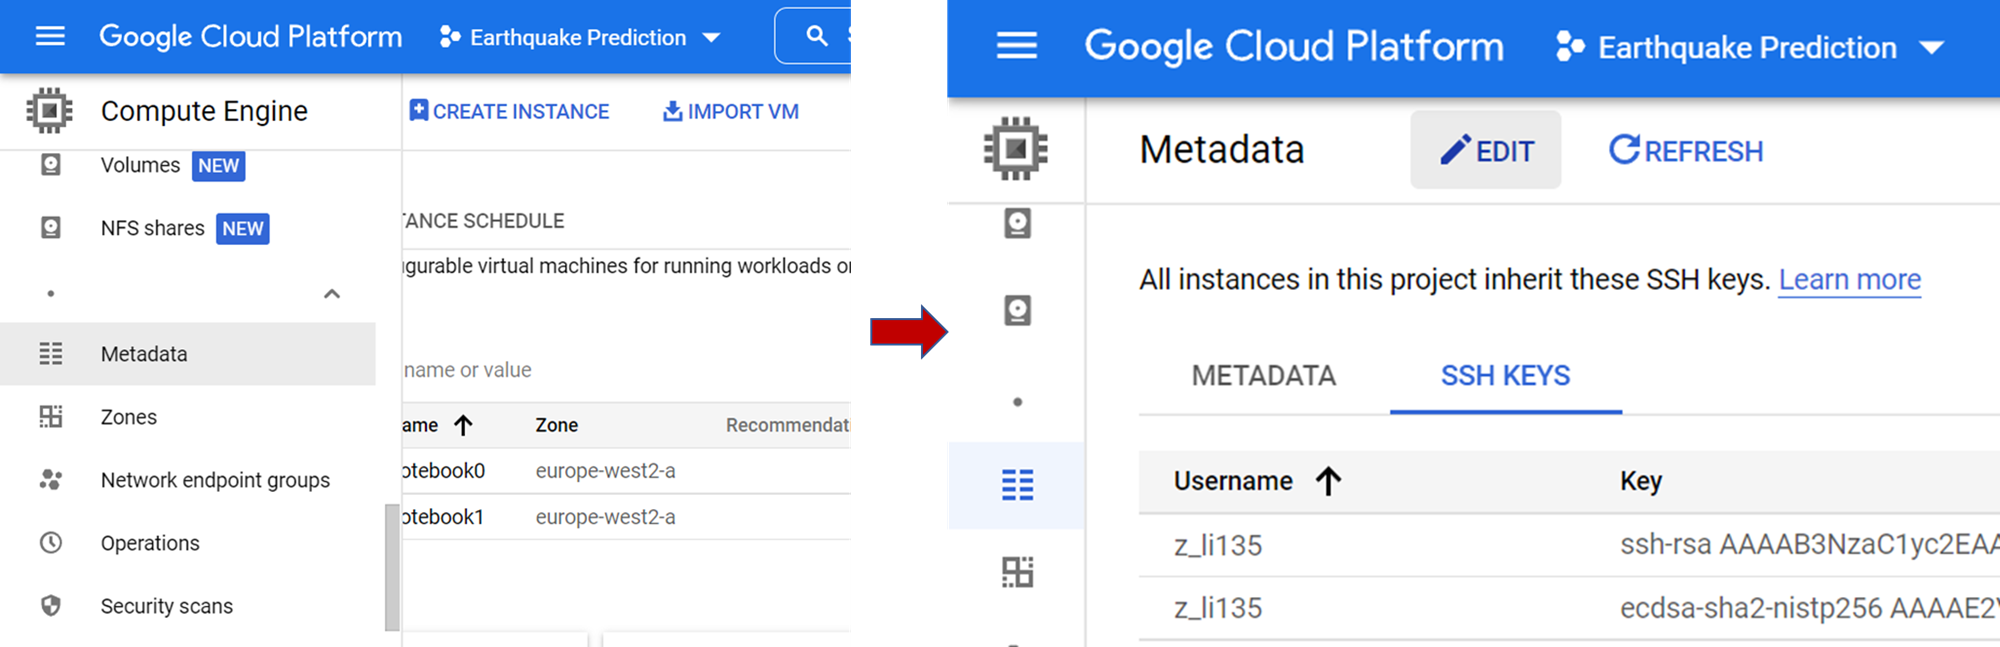

In [46]:
Image(filename='ST446/2.4.png', width=1200)

#### **2.5. Add and save the public key just generated**

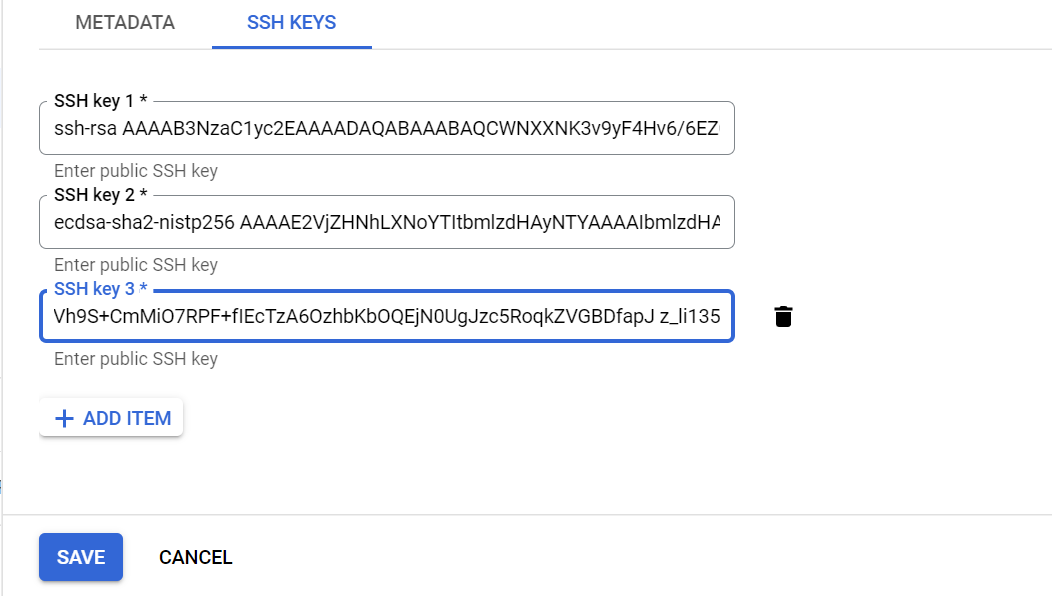

In [22]:
Image(filename='ST446/2.5.png', width=750)

#### **2.6. Repeat the above work on each VM**


Upon completion, you can switch between different virtual machines.


notebook0 -> notebook1:

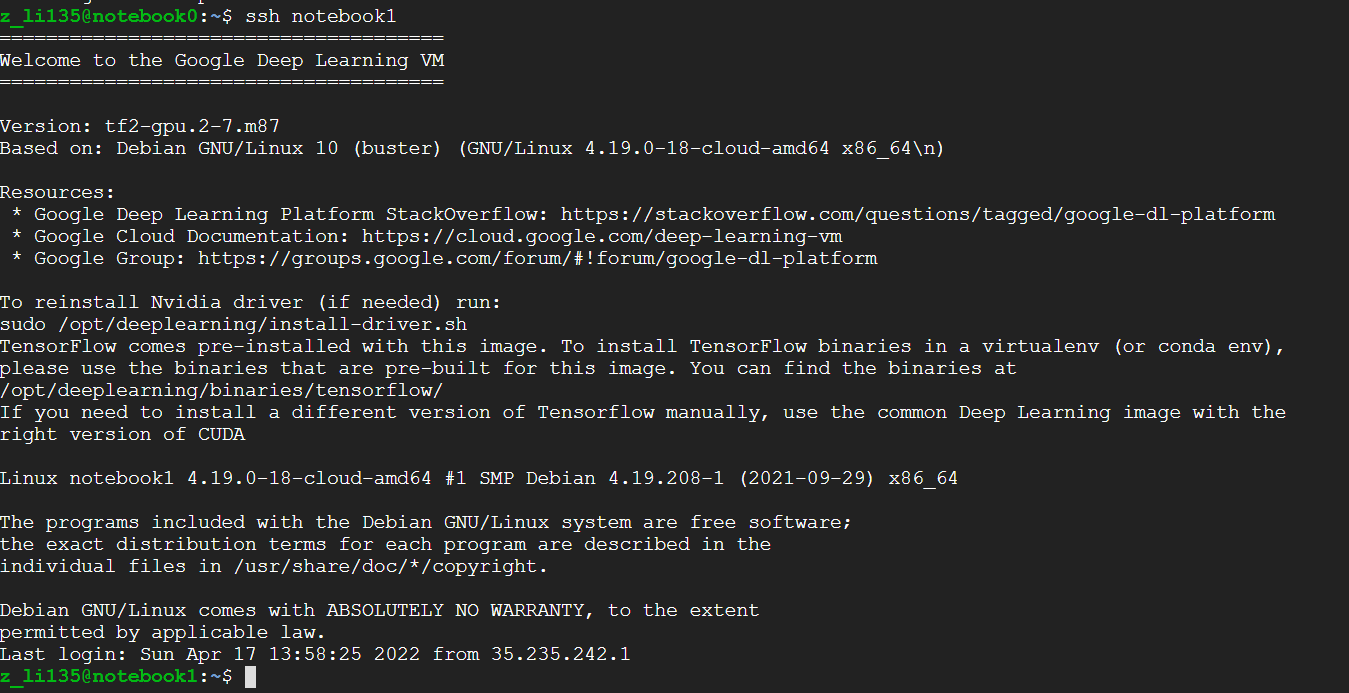

In [47]:
Image(filename='ST446/2.61.png', width=1200)

notebook1 -> notebook0:

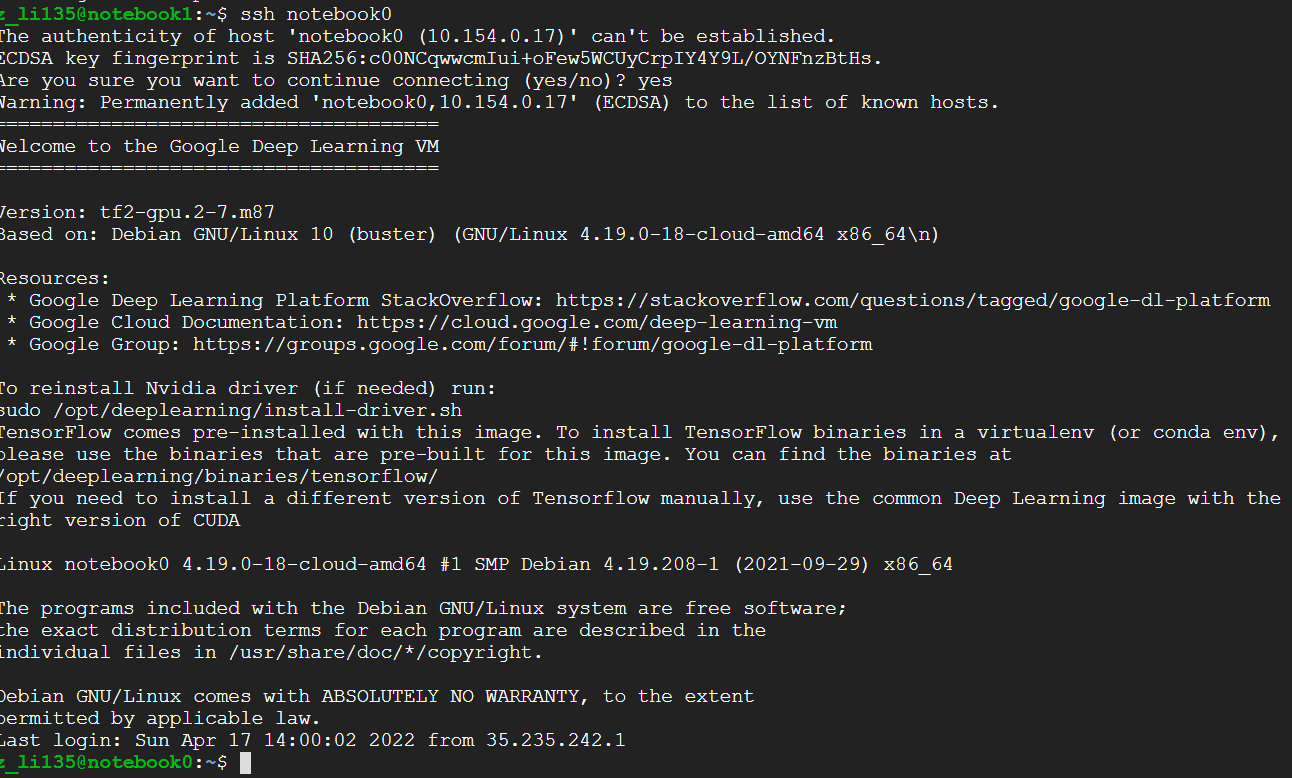

In [48]:
Image(filename='ST446/2.62.png', width=1200)

### **3. Create firewall rules**

The default firewall rules for GCP only allow ingress operations between virtual machines. In distributed computing, data moves inward and outward, so egression needs to be enabled manually. It is necessary to create egression rules.

#### **3.1. On the VM instances interface, click "⋮" on the right side of any VM and click "View network details".**


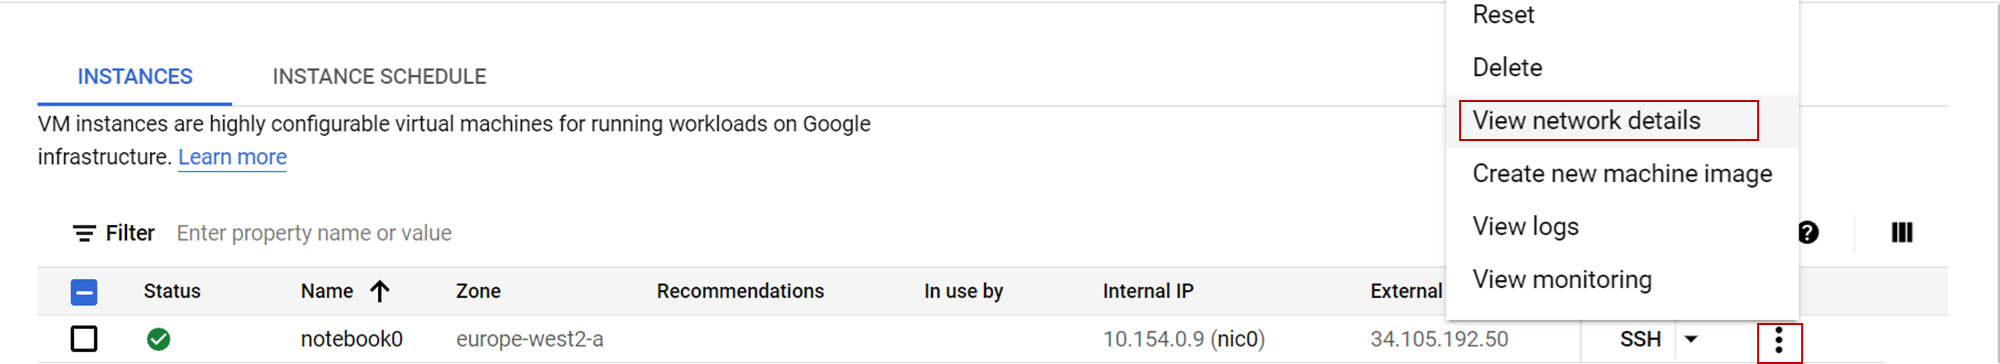

In [49]:
Image(filename='ST446/3.1.png', width=1200)


#### **3.2. Find firewall on the left side of the page and click to enter.**


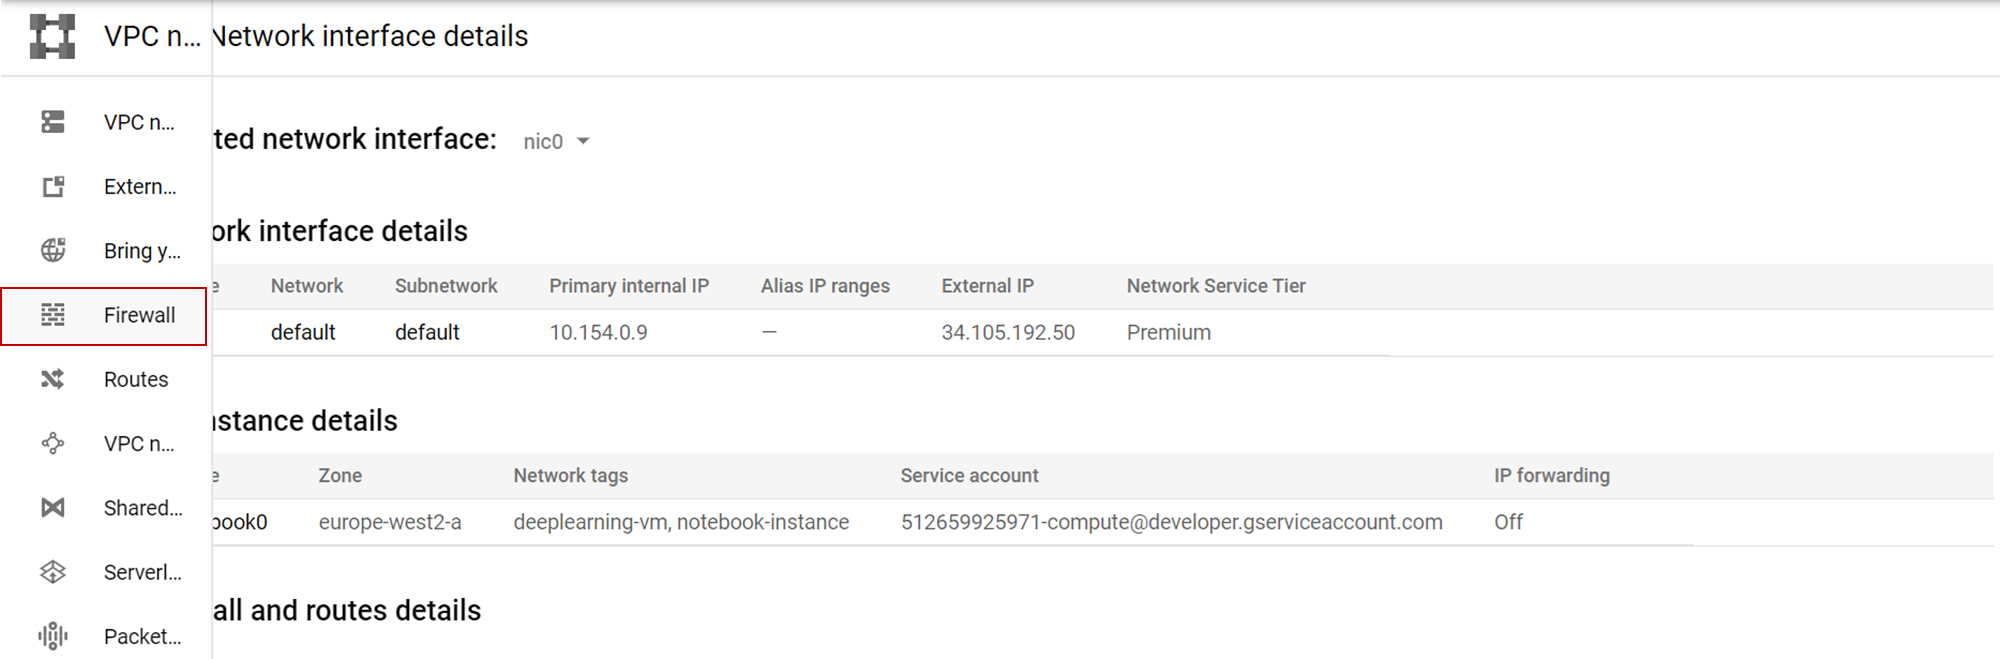

In [50]:
Image(filename='ST446/3.2.png', width=1200)

#### **3.3. Find the two rules circled in red.**

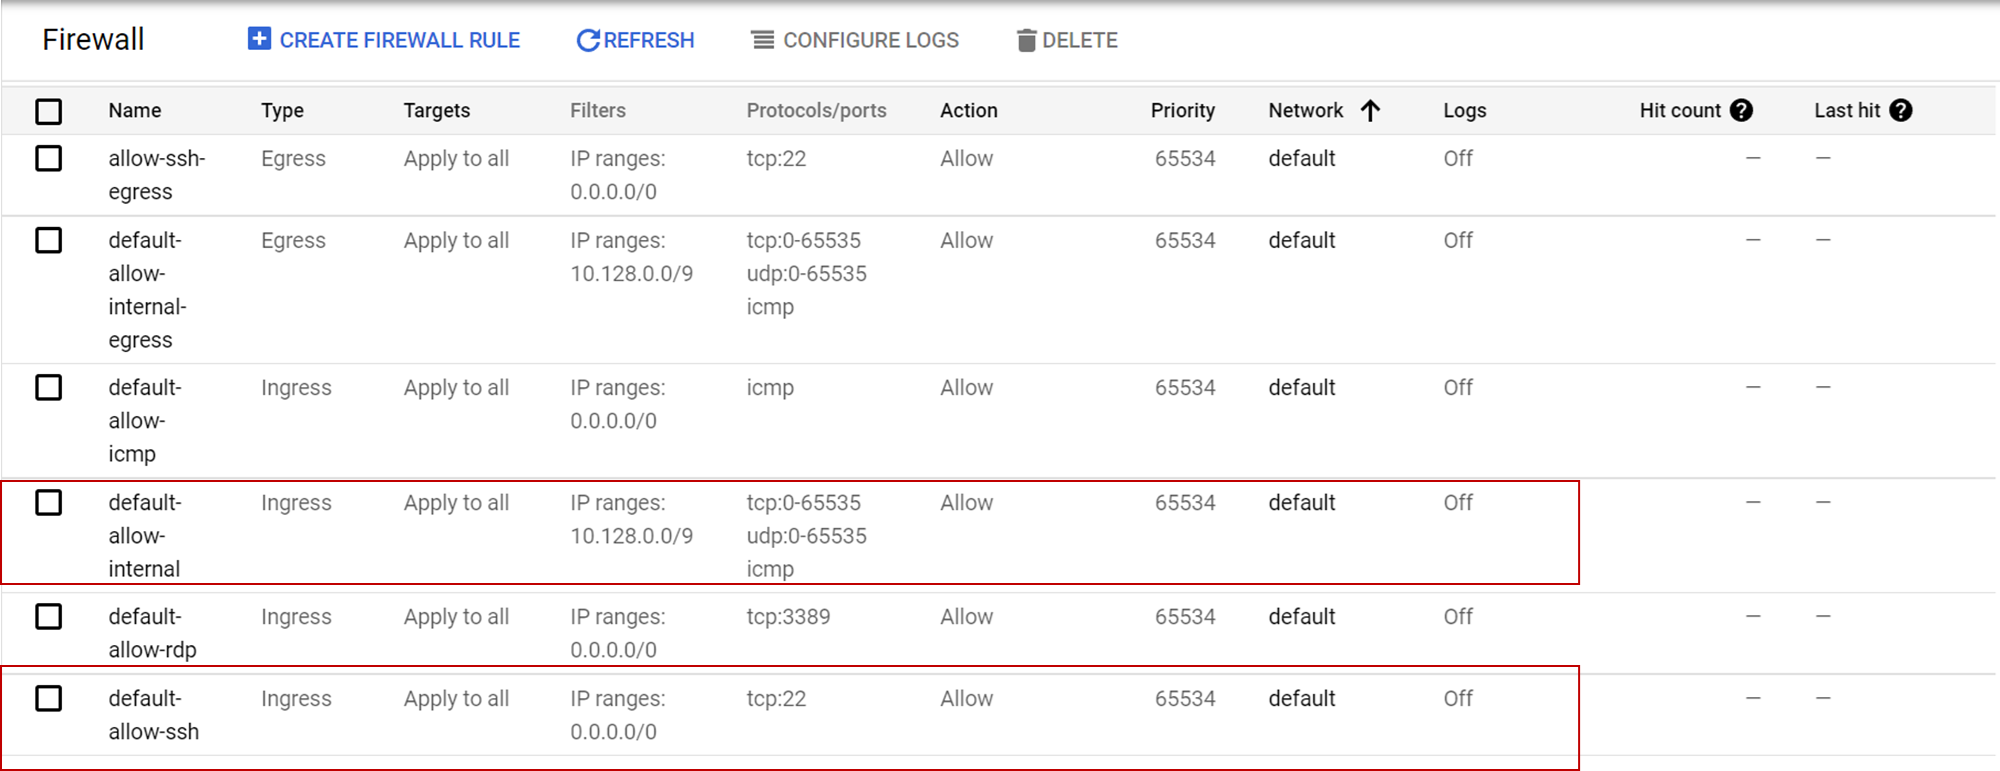

In [51]:
Image(filename='ST446/3.3.png', width=1200)

#### **3.4. Create two new rules according to the two rules circled in the red box, except that the Direction of traffic is selected as Egress, the others remain the same.**


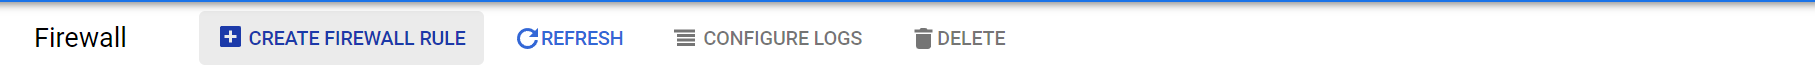

In [52]:
Image(filename='ST446/3.40.png', width=1200)

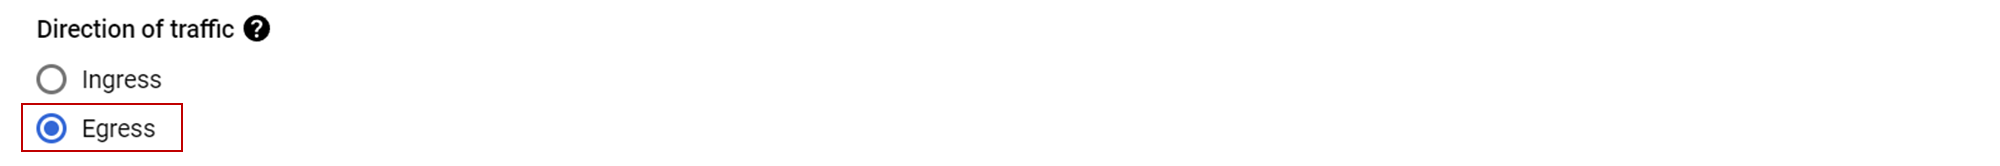

In [53]:
Image(filename='ST446/3.41.png', width=1200)

#### The newly added rules are circled in orange, and the firewall is now set up.

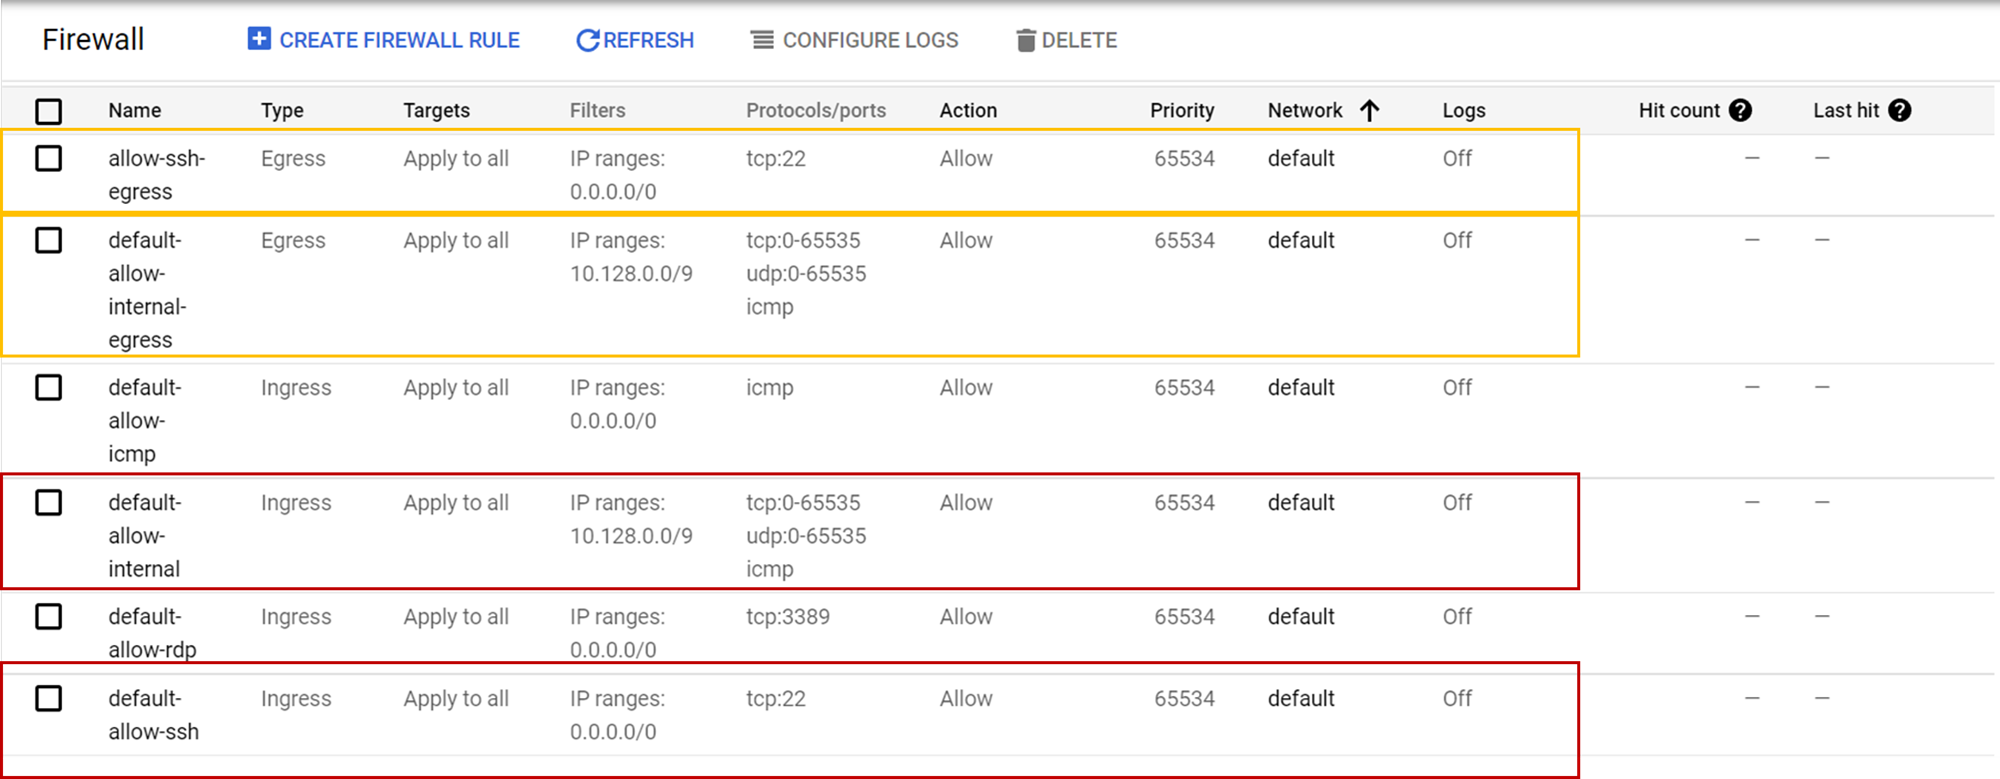

In [54]:
Image(filename='ST446/3.42.png', width=1200)

## Having completed the above three steps, an environment based on HOROVOD can be set up for distributed computing, which in turn allows the model to be trained.

### **Example**

#### This example uses a compression technique from Horovod called FP16Compressor. Our own compression algorithm can be implemented by imitating the script from this compressor.


#### **1. In the notebook corresponding to each VM, upload the Python code for training**
train_demo1.py address：

https://github.com/DrinkIceWater/ST446-Temporary/blob/main/train_demo1.py


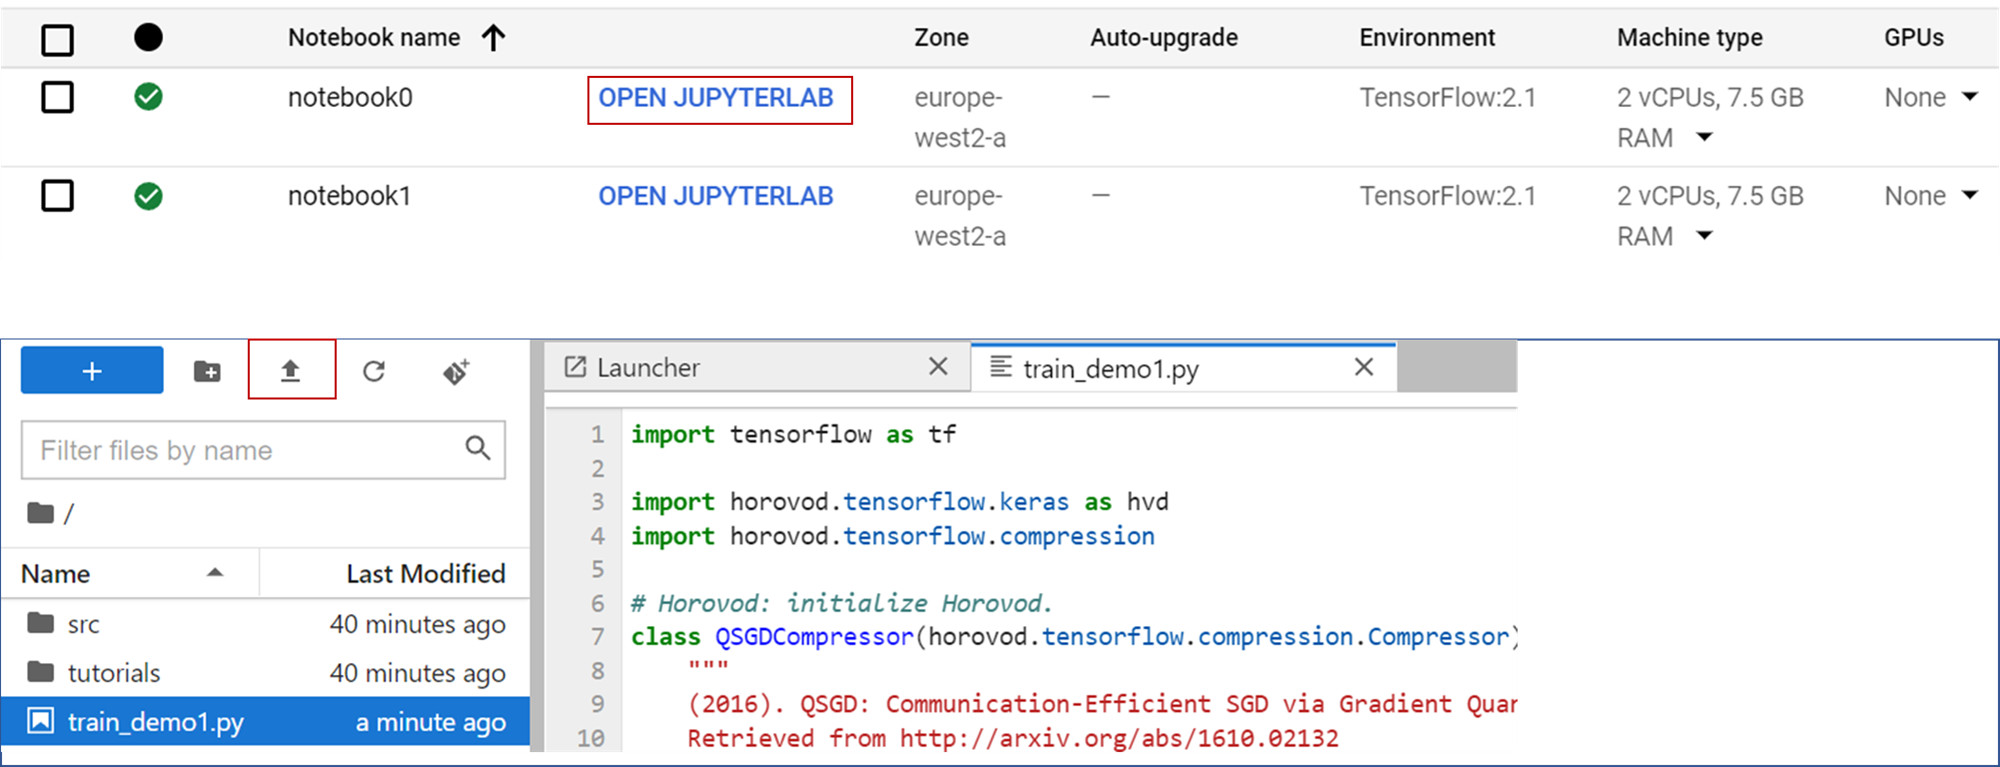

In [55]:
Image(filename='ST446/41.png', width=1200)

#### **2. Go back to the VM instances interface, use ssh to connect any VM first, and enter the following code:**

`horovodrun -np 2 -H notebook0:1,notebook1:1 python ../jupyter/train_demo1.py` 


Note: "-np" refers to the total number of processes, and "notebook0:1,notebook1:1" means that the two virtual machines, notebook0 and notebook1, execute a process each.


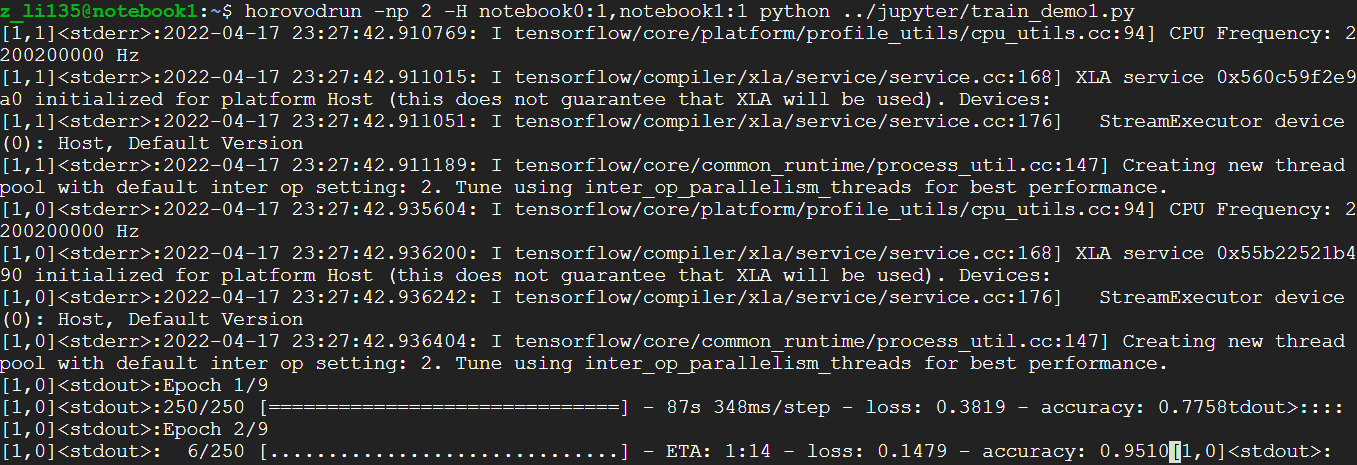

In [56]:
Image(filename='ST446/42.png', width=1200)

#### Applaud yourself when you see the above scene... the model is already training! 

### **II.Write a Training Script in Horovod Style**

#### Import modules
__Note:__ CompressionTechnique is a python script file containing the compression techniques we defined. At this stage, feel free to uncomment it.

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
import tensorflow as tf
import horovod.tensorflow.keras as hvd
import horovod.tensorflow.compression
from horovod.tensorflow.compression import FP16Compressor, NoneCompressor
#from CompressionTechnique import RandomkCompressor, TopkCompressor, SketchCompressor, QSGDCompressor


#### Customise a Callback
This callback helps us to get the information of training time.

In [ ]:
############################################# ADDED #############################################
import time
import pandas as pd

# record the training time for each epoch
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    # def on_train_end(self, logs={}):
    #     logs['time'] = self.times
        
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        logs['time'] = self.times[-1]
############################################# ADDED #############################################

#### Experimental Table
The main hyperparameters are listed here, you can tune them to achieve optimal performance of distributed training.   
`batch`: batch size of each iteration   
`lr`: learning rate. It is not necessarily a constant. You can define a function to make it adaptive to the training.   
`compression`: compression techniques. The default is NoneCompressor. We will introduce how to define a customized compression technique later    
`initial_lr`:Horovod allows the learning rate to vary in the first few epochs automatically, so we can define an initial learning rate here.   
`step_per_epoch`: Define the number of iterations per epoch.   
`epoch`: The number of time traversing the dataset.    
`backward_passes_per_step`: The number of local iterations before updating the model.   
`average_aggregated_gradients`

In [ ]:
##################################################################
####################### EXPERIMENTAL TABLE #######################
## YOU CAN ADJUST PARAMETERS BELOW TO EXAMINE THE PERFORMANCE   ##
## OF DIFFERENT DISTRIBUTED TRAINING SETTINGS.                  ##
##################################################################

##-- batchsize --##
batch = 128

##-- learning rate --##
lr = 0.001

##- compression technique --##
# You can choose from [NoneCompressor, FP16Compressor, RandomkCompressor, TopkCompressor, SketchCompressor]
compression = NoneCompressor


##-initial learning rate --##
initial_lr = 0.001

##- steps per epoch --##
steps_per_epoch = 200

##-- epochs --##
epochs = 20

##-- backward passes per step --##
backward_passes_per_step = 1

##-- average aggregated gradients --##
average_aggregated_gradients = True
 
####################################################################
####################################################################

#### Initialize Horovod and check GPU
If there is no GPU, CPU will be used for computing automatically.

In [ ]:
# Horovod: initialize Horovod.
hvd.init()

# Horovod: pin GPU to be used to process local rank (one GPU per process)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')

#### Get the Dataset

In [ ]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255

# If subtract pixel mean is enabled

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, 10)

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(x_train[..., tf.newaxis], tf.float32),
                                  tf.cast(y_train, tf.int64))
)

dataset = dataset.repeat().shuffle(10000).batch(batch)

#### Define a Model
The model is a ResNet model with more than 660,000 parameters. The code is from: https://keras.io/zh/examples/cifar10_resnet/.

In [ ]:
n = 7
depth = n * 6 + 2

#####################################################################################
#####################################################################################
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = resnet_v1(input_shape=input_shape, depth=depth)

#### Distributed Optimiser
hvd.DistributedOptimizer is a key element in horovod distributed training, in which we can define the type of optimiser (SGD,Adam ect.), specify the number of local iterations and which compression technique to use. After creating an object of horovod DistributedOptimiser, we can simpy pass it into TensorFlow as the optimiser.   

__Note:__ You should state "tf.config.run_functions_eagerly(True)" here, as some compression techniques may use python modules and functions. Withou specifying it, you could only use the methods of tensorflow. In tensorflow 2.2 or earlier, compression techniques cannot be defined using methods outside tensorflow, becasue DistributedOptimizer requires eager execution to be disabled.  

In [ ]:
opt = tf.optimizers.Adam(lr * hvd.size())

tf.config.run_functions_eagerly(True)
# Horovod: add Horovod DistributedOptimizer.
opt = hvd.DistributedOptimizer(opt, backward_passes_per_step = backward_passes_per_step, average_aggregated_gradients = average_aggregated_gradients, compression = compression)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


#### Define Callbacks

In [ ]:
callbacks = [
    # Horovod: broadcast initial variable states from rank 0 to all other processes.
    # This is necessary to ensure consistent initialization of all workers when
    # training is started with random weights or restored from a checkpoint.
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),

    # Horovod: average metrics among workers at the end of every epoch.
    #
    # Note: This callback must be in the list before the ReduceLROnPlateau,
    # TensorBoard or other metrics-based callbacks.
    hvd.callbacks.MetricAverageCallback(),

    # Horovod: using `lr = 1.0 * hvd.size()` from the very beginning leads to worse final
    # accuracy. Scale the learning rate `lr = 1.0` ---> `lr = 1.0 * hvd.size()` during
    # the first three epochs. See https://arxiv.org/abs/1706.02677 for details.
    hvd.callbacks.LearningRateWarmupCallback(initial_lr = initial_lr, warmup_epochs=3, verbose=1),
    
    TimeHistory()
]

#### Fit the model

In [ ]:
# Horovod: write logs on worker 0.
verbose = 1 if hvd.rank() == 0 else 0

# Train the model.
# Horovod: adjust number of steps based on number of GPUs.
#mnist_model.fit(dataset, steps_per_epoch=500, callbacks=callbacks, epochs=9, verbose=verbose)
history = model.fit(dataset, steps_per_epoch=steps_per_epoch // hvd.size(), callbacks=callbacks, epochs=epochs, verbose=verbose)

if hvd.rank() == 0:
    res = pd.DataFrame(history.history)
    res.to_csv('result.csv')

You can simply put the script on each machine without any modification, and use horovodrun to execute the script simutaneously.

#### By now, we believe you already know how to do distributed training with horovod. Then we will introduce how to define a compression technique.

### III. Define a Customized Compression Technique: QSGD

In [ ]:
import tensorflow as tf
import numpy as np
# From horovod impoprt the class of compressor
from horovod.tensorflow.compression import Compressor

In horovod, it is easy to define a compressor. We need to define two static methods in the class of compressor, one for compressing, and the another for decompressing. The code below shows the stucture of the Compressor class.

In [ ]:
class Compressor(object):
    """Interface for compressing and decompressing a given tensor."""
    @staticmethod
    def compress(tensor):
        """Compresses a tensor and returns it with the context needed to decompress it."""
        pass

    @staticmethod
    def decompress(tensor, ctx):
        """Decompress the tensor with the given context."""
        pass

#### Example: QSGD

We define the compression technique according to its definition.

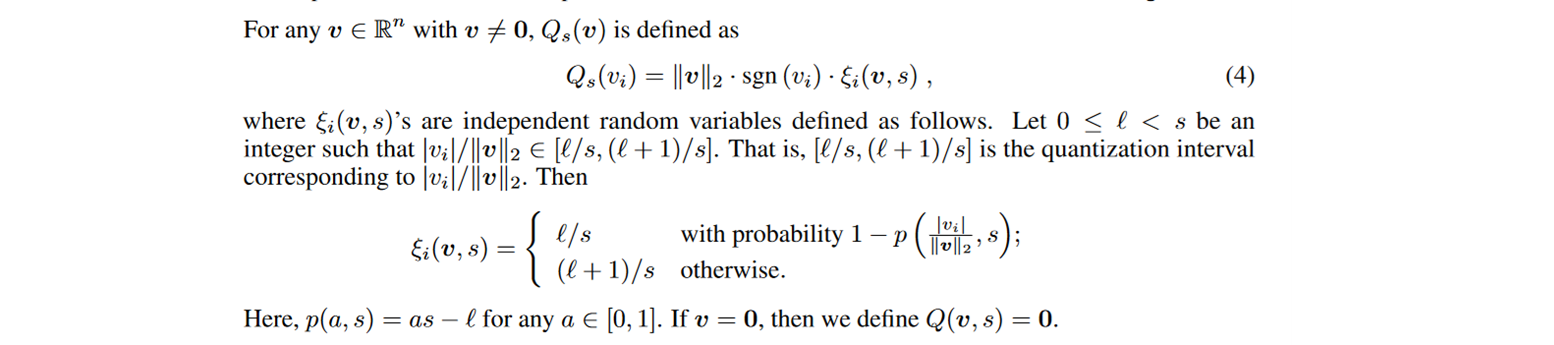

Quantized value is the product of the following three components：`a)`$\Vert \nu \Vert _{2}$; `b)`$sgn(\nu_{i})$; `c)`$\xi_{i}(\nu, s)$。   
The definition above is for single value. For convenience, we do matrix manipulation in practice.   
`a)` $\Vert \nu \Vert _{2}$ is a scalar. It is the L2 norm of the parameter vector.The formula is $\Vert \nu \Vert _{2} = \sqrt{\sum_{i}^{n}\nu_{i}^2}$. We can use np.linalg.norm() to calculate it. Before the calculation, we need firstly covert the tensor into a vector. When receiving a tensor t($t \in R^{m\times n}$) as input,we will convert it into a vector $\nu$ ($\nu \in R^{(m \times n) \times 1}$) with m$\times$n elements.    
`b)` $sgn(\nu_{i})$is the sign of $\nu_{i}$. We can use np.sign() to get the result.  
`c)`$\xi_{i}(\nu, s)$ is a value calculated from $\nu_{i}$ and a predetermined parameter $s$.The formula of calculating the probability is given above. In implementing stage, we will firstly get the probability vector and use uniform distribution to simulate the Bernoulli distribution above.

In [ ]:
ts = np.array([[random.random() for i in range(10)] for j in range(5)])
ts = tf.convert_to_tensor(ts)

s = 3

# 0）convert tensor into numpy array
para = ts.numpy()

# a)calculate the L2norm of v
## convert the tensor into a vector
v = np.reshape(para, -1)
## Calculte the L2norm
l2norm = np.linalg.norm(para)

# b)get the sign of vector
sgn = np.sign(v)

# c)Calculate the random variable
## get l
l = np.floor(((abs(v) / l2norm) * s))
## get p(a,s)
p = (abs(v) / l2norm) * s - l
## use uniform distribution to simulate the Bernoulli distribution
xi = (np.random.uniform(size = len(v)) >= p) * (l/s) + (np.random.uniform(size = len(v)) < p) * ((l+1)/s)
##zeta = xi * s
zeta = (np.random.uniform(size = len(v)) >= p) * (l) + (np.random.uniform(size = len(v)) < p) * (l)

#get quantized vector
quantized_v = l2norm * sgn * xi

#### Coding Technique — Elias Coding

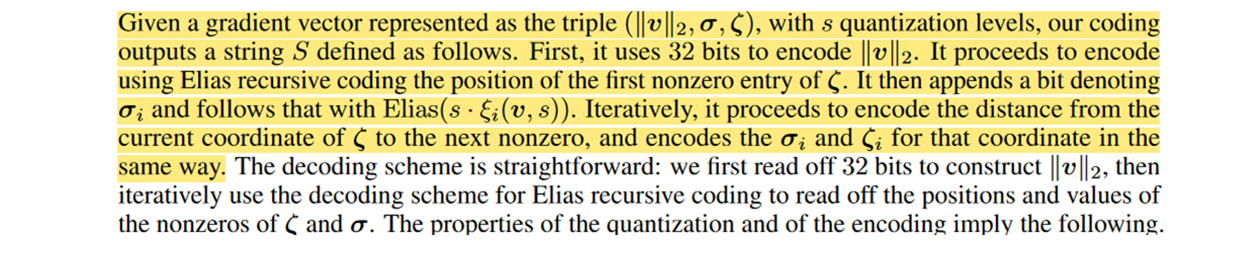

In [ ]:
def elias_encode(num):
    if num == 1:
        return '1'
    n = int(np.math.log2(num)) 
    remain = num - pow(2, n)
    return '0' * (len(bin(n+1))-3) + str(bin(n+1)[2:]) + bin(remain)[2:].rjust(n, '0')


def elias_decoding(x):
    L = 0
    while True:
        if not x[L] == '0':
            break
        L += 1

    power = x[L: 2*L+1]
    digit = int(power, 2) - 1
    add = x[2*L+1: 2*L+digit+1]
    if len(add) == 0:
        add = '0'

    return pow(2, int(digit)) + int(add, 2)


#### The following function is for decoding a sequence of encoded values

In [ ]:
def sequential_decode(string):
    left = -1
    right = -1
    ls = []
    while right < len(string)-1:
        right += 1
        if int(string[right]) == 0:
            continue
        else:
            num_zero = right - left - 1

            interval = int(string[right:right+num_zero+1], 2) + 2*num_zero
            ls.append(Elias_Delta_Decoding(string[left+1:left+1+interval]))

            right = left + interval
            left = right
    return ls


#### The following function is for storing the encoded value in bits
The main idea is to split the sequence into segments with fixed size and convert them into decimal form. The following graph shows the situation where bitwise elements are stored in int8.
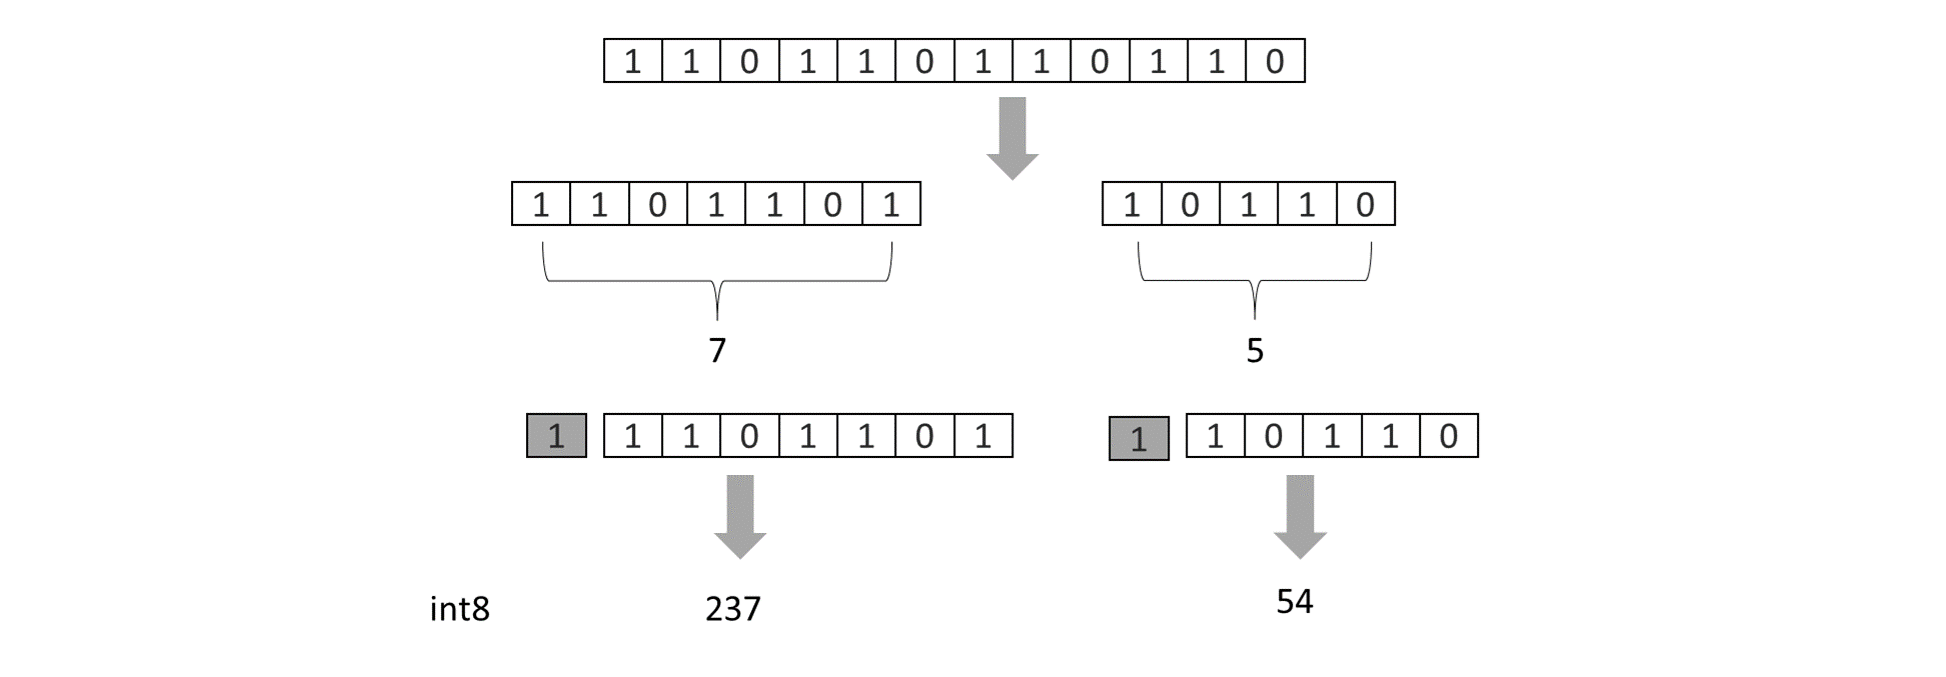

In [ ]:
def to_bit(string, length = 32):
    d = length - 2
    ls = []
    quotient, remainder = int(len(string)//d), int(len(string) % d)

    if quotient == 0 and remainder != 0:
        ls.append(int('1'+ string,2))

    elif quotient != 0 and remainder == 0:
        for i in range(quotient):
            ls.append(int('1' + string[i*d:i*d+d], 2))

    elif quotient != 0 and remainder != 0:
        for i in range(quotient):
            ls.append(int('1' + string[i*d:i*d+d], 2))
        ls.append(int('1'+ string[-remainder:],2))

    else:
        pass


    ls = np.array(ls, dtype = np.dtype('int32'))


    ls = tf.convert_to_tensor(ls)
    return ls

#If there is no nonzero entry
if len(abs_position[0]) < 1:
    zeta_position = '11'
    sign = '1'
    return tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

#If there is only one nonzero entry
if len(abs_position[0]) == 1:

    zeta_position = elias_encode(int(zeta[abs_position[0][0]])) + '1'
    sign = str(int(sgn[abs_position[0][0]] > 0))
    return  tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

#### The following is the full script of QSGD

In [ ]:
class QSGDCompressor(Compressor):
    @staticmethod
    def compress(tensor):
        tf.config.run_functions_eagerly(True)
        
        s = 3
        #get
        tensor_shape = tf.shape(tensor)
        # 0）convert tensor into numpy array
        para = ts.numpy()

        # a)calculate the L2norm of v
        ## convert the tensor into a vector
        v = np.reshape(para, -1)
        ## Calculte the L2norm
        l2norm = np.linalg.norm(para)

        # b)get the sign of vector
        sgn = np.sign(v)

        # c)Calculate the random variable
        ## get l
        l = np.floor(((abs(v) / l2norm) * s))
        ## get p(a,s)
        p = (abs(v) / l2norm) * s - l
        ## use uniform distribution to simulate the Bernoulli distribution
        xi = (np.random.uniform(size = len(v)) >= p) * (l/s) + (np.random.uniform(size = len(v)) < p) * ((l+1)/s)
        ##zeta = xi * s
        zeta = (np.random.uniform(size = len(v)) >= p) * (l) + (np.random.uniform(size = len(v)) < p) * (l)

        zeta = np.array(zeta, np.dtype('int32'))
        
        ####quantized_v = l2norm * sgn * xi


        def elias_encode(num):
            if num == 1:
                return '1'
            n = int(np.math.log2(num)) 
            remain = num - pow(2, n)
            return '0' * (len(bin(n+1))-3) + str(bin(n+1)[2:]) + bin(remain)[2:].rjust(n, '0')


        #Encode
        ##nonzero zeta and its position
        abs_position = np.nonzero(zeta)
        abs_position = np.array(abs_position, np.dtype('int32'))
        

        def to_bit(string, length = 32):
            d = length - 2
            ls = []
            quotient, remainder = int(len(string)//d), int(len(string) % d)

            if quotient == 0 and remainder != 0:
                ls.append(int('1'+ string,2))

            elif quotient != 0 and remainder == 0:
                for i in range(quotient):
                    ls.append(int('1' + string[i*d:i*d+d], 2))

            elif quotient != 0 and remainder != 0:
                for i in range(quotient):
                    ls.append(int('1' + string[i*d:i*d+d], 2))
                ls.append(int('1'+ string[-remainder:],2))

            else:
                pass


            ls = np.array(ls, dtype = np.dtype('int32'))


            ls = tf.convert_to_tensor(ls)
            return ls

        #If there is no nonzero entry
        if len(abs_position[0]) < 1:
            zeta_position = '11'
            sign = '1'
            return tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

        #If there is only one nonzero entry
        if len(abs_position[0]) == 1:

            zeta_position = elias_encode(int(zeta[abs_position[0][0]])) + '1'
            sign = str(int(sgn[abs_position[0][0]] > 0))
            return  tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

        

        aux_ls = list(abs_position[0])[:-1]
        aux_ls.insert(0,0)
        relative_position = abs_position - np.array(aux_ls)

        zeta_position = ''.join([elias_encode(int(zeta[i])) for i in abs_position[0]]) + ''.join(([elias_encode(x+1) for x in relative_position[0]]))
        ##the sign of nonzero entry
        sign = ''.join([str(int(sgn[i] > 0)) for i in abs_position[0]])

        #convert 010101 into decimal form

        return tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

    @staticmethod
    def decompress(tensor, ctx):
        tf.config.run_functions_eagerly(True)

        def Elias_Delta_Decoding(x):
            L = 0
            while True:
                if not x[L] == '0':
                    break
                L += 1

            power = x[L: 2*L+1]
            digit = int(power, 2) - 1
            add = x[2*L+1: 2*L+digit+1]
            if len(add) == 0:
                add = '0'

            return pow(2, int(digit)) + int(add, 2)

        def sequential_decode(string):
            left = -1
            right = -1
            ls = []
            while right < len(string)-1:
                right += 1
                if int(string[right]) == 0:
                    continue
                else:
                    num_zero = right - left - 1

                    interval = int(string[right:right+num_zero+1], 2) + 2*num_zero
                    ls.append(Elias_Delta_Decoding(string[left+1:left+1+interval]))

                    right = left + interval
                    left = right
            return ls

        
        s = 3


        #get L2Norm
        l2norm = ctx[1]
         #get the shape of the original tensor
        tensor_shape = tensor
        
        tensor = ctx[0]
        #get the encoded zeta and its position
        zeta_position = ''.join([bin(i)[3:] for i in tensor.numpy()])
        #get the sign
        sign = ''.join([bin(i)[3:] for i in ctx[2].numpy()])
       
        
        

        
        ##decode zeta and position
        zeta_position = sequential_decode(zeta_position)

        
        zeta, relative_position = zeta_position[:int(len(zeta_position)/2)], zeta_position[int(len(zeta_position)/2):]

        # When encoding, we code the distance between consecutive non-zero elements as 1 
        # (because the elias code cannot be 0 encoded), and the first position is the absolute position,
        # so the next line of code must be the position of the first element minus 1.
        relative_position = np.array(relative_position) - 1
        #cummulating sum to get the absolute position
        abs_position = np.cumsum(np.array(relative_position))

        #get quantized vector
        quantized_v = ((np.array(zeta) * l2norm) / s) * np.array([1 if x == '1' else -1 for x in sign])

        #create a zero vector

        length = np.prod(tensor_shape.numpy())
        zero_ls = np.zeros(length)
        #according to the position of nonzero entry, assign the value to the corresponding position
        for i in range(len(abs_position)):
            zero_ls[abs_position[i]] = quantized_v[i]

        # convert the vector into tensor according to the tensor shape
        dcp_tensor = tf.reshape(tf.cast(zero_ls, dtype=tf.float32), tensor_shape)

    #return dcp_tensor
        return dcp_tensor

## Appendix

#### 1.SetupScriptforTensorFlow.py
#### 2.TensorFlowTrainingScript.py
#### 3.HorovodTrainingScript.py
#### 4.CompressionTechnique.py

#### 1.SetupScriptforTensorFlow.py

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10

import os
import tensorflow as tf
import numpy as np

def cifar10_dataset(batch):
    # Load the CIFAR10 data.
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Input image dimensions.
    input_shape = x_train.shape[1:]

    # Normalize data.
    x_train = x_train.astype('float32') / 255

    # If subtract pixel mean is enabled

    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean

    # Convert class vectors to binary class matrices.
    y_train = tf.keras.utils.to_categorical(y_train, 10)

    dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_train[..., tf.newaxis], tf.float32),
                                      tf.cast(y_train, tf.int64))
    )

    dataset = dataset.repeat().shuffle(10000).batch(batch)
    return dataset



def build_and_compile_ResNet_model():
    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation='relu',
                     batch_normalization=True,
                     conv_first=True):

        conv = Conv2D(num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=l2(1e-4))

        x = inputs
        if conv_first:
            x = conv(x)
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
        else:
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
            x = conv(x)
        return x

    def resnet_v1(input_shape, depth = 44, num_classes=10):
        if (depth - 2) % 6 != 0:
            raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
        # Start model definition.
        num_filters = 16
        num_res_blocks = int((depth - 2) / 6)

        inputs = Input(shape=input_shape)
        x = resnet_layer(inputs=inputs)
        # Instantiate the stack of residual units
        for stack in range(3):
            for res_block in range(num_res_blocks):
                strides = 1
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides = 2  # downsample
                y = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 strides=strides)
                y = resnet_layer(inputs=y,
                                 num_filters=num_filters,
                                 activation=None)
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    # linear projection residual shortcut connection to match
                    # changed dims
                    x = resnet_layer(inputs=x,
                                     num_filters=num_filters,
                                     kernel_size=1,
                                     strides=strides,
                                     activation=None,
                                     batch_normalization=False)
                x = keras.layers.add([x, y])
                x = Activation('relu')(x)
            num_filters *= 2

        # Add classifier on top.
        # v1 does not use BN after last shortcut connection-ReLU
        x = AveragePooling2D(pool_size=8)(x)
        y = Flatten()(x)
        outputs = Dense(num_classes,
                        activation='softmax',
                        kernel_initializer='he_normal')(y)

        # Instantiate model.
        model = Model(inputs=inputs, outputs=outputs)
        
        return model
    
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    input_shape = x_train.shape[1:]
    
    model = resnet_v1(input_shape=input_shape, depth=44)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.optimizers.Adam(0.001),
                  metrics=['accuracy'])
    return model

#### 2.TensorFlowTrainingScript.py

In [ ]:
import os
import json

import tensorflow as tf

import numpy as np
import sys

import SetupScriptforTensorFlow


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ.pop('TF_CONFIG', None)

if '.' not in sys.path:
    sys.path.insert(0, '.')

os.environ["TF_CONFIG"] = json.dumps({
    'cluster': {
        'worker': ["10.154.0.2:12345", "10.154.0.3:12345", "10.154.0.4:12345"]
    },
    'task': {'type': 'worker', 'index': 2}
})

per_worker_batch_size = 128
tf_config = json.loads(os.environ['TF_CONFIG'])
num_workers = len(tf_config['cluster']['worker'])

strategy = tf.distribute.MultiWorkerMirroredStrategy()

global_batch_size = per_worker_batch_size * num_workers
multi_worker_dataset = SetupScriptforTensorFlow.cifar10_dataset(global_batch_size)

with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
  multi_worker_model = SetupScriptforTensorFlow.build_and_compile_ResNet_model()


multi_worker_model.fit(multi_worker_dataset, epochs=20, steps_per_epoch=200 // num_workers )

#### 3.HorovodTrainingScript.py

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
import tensorflow as tf
import horovod.tensorflow.keras as hvd
import horovod.tensorflow.compression
from horovod.tensorflow.compression import FP16Compressor, NoneCompressor
from CompressionTechnique import RandomkCompressor, TopkCompressor, SketchCompressor, QSGDCompressor




############################################# ADDED #############################################
import time
import pandas as pd

# record the training time for each epoch
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    # def on_train_end(self, logs={}):
    #     logs['time'] = self.times
        
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        logs['time'] = self.times[-1]
############################################# ADDED #############################################


##################################################################
####################### EXPERIMENTAL TABLE #######################
## YOU CAN ADJUST PARAMETERS BELOW TO EXAMINE THE PERFORMANCE   ##
## OF DIFFERENT DISTRIBUTED TRAINING SETTINGS.                  ##
##################################################################

##-- batchsize --##
batch = 128

##-- learning rate --##
lr = 0.001

##- compression technique --##
# You can choose from [NoneCompressor, FP16Compressor, RandomkCompressor, TopkCompressor, SketchCompressor]
compression = NoneCompressor


##-initial learning rate --##
initial_lr = 0.001

##- steps per epoch --##
steps_per_epoch = 200

##-- epochs --##
epochs = 20

##-- backward passes per step --##
backward_passes_per_step = 1

##-- average aggregated gradients --##
average_aggregated_gradients = True
 
####################################################################
####################################################################
    

# Horovod: initialize Horovod.
hvd.init()

# Horovod: pin GPU to be used to process local rank (one GPU per process)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    
n = 7
depth = n * 6 + 2

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255

# If subtract pixel mean is enabled

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, 10)

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(x_train[..., tf.newaxis], tf.float32),
                                  tf.cast(y_train, tf.int64))
)

dataset = dataset.repeat().shuffle(10000).batch(batch)

#####################################################################################
#####################################################################################
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = resnet_v1(input_shape=input_shape, depth=depth)


opt = tf.optimizers.Adam(lr * hvd.size())

tf.config.run_functions_eagerly(True)
# Horovod: add Horovod DistributedOptimizer.
opt = hvd.DistributedOptimizer(opt, backward_passes_per_step = backward_passes_per_step, average_aggregated_gradients = average_aggregated_gradients, compression = compression)
#opt = hvd.DistributedOptimizer(opt, compression = horovod.tensorflow.compression.FP16Compressor)
#opt = hvd.DistributedOptimizer(opt, compression = horovod.tensorflow.compression.NoneCompressor,backward_passes_per_step = 1, average_aggregated_gradients = True)
# Horovod: Specify `experimental_run_tf_function=False` to ensure TensorFlow
# uses hvd.DistributedOptimizer() to compute gradients.
#mnist_model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),
#                    optimizer=opt,
#                    metrics=['accuracy'],
#                    experimental_run_tf_function = False)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

callbacks = [
    # Horovod: broadcast initial variable states from rank 0 to all other processes.
    # This is necessary to ensure consistent initialization of all workers when
    # training is started with random weights or restored from a checkpoint.
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),

    # Horovod: average metrics among workers at the end of every epoch.
    #
    # Note: This callback must be in the list before the ReduceLROnPlateau,
    # TensorBoard or other metrics-based callbacks.
    hvd.callbacks.MetricAverageCallback(),

    # Horovod: using `lr = 1.0 * hvd.size()` from the very beginning leads to worse final
    # accuracy. Scale the learning rate `lr = 1.0` ---> `lr = 1.0 * hvd.size()` during
    # the first three epochs. See https://arxiv.org/abs/1706.02677 for details.
    hvd.callbacks.LearningRateWarmupCallback(initial_lr = initial_lr, warmup_epochs=3, verbose=1),
    
    TimeHistory()
]


# Horovod: write logs on worker 0.
verbose = 1 if hvd.rank() == 0 else 0

# Train the model.
# Horovod: adjust number of steps based on number of GPUs.
#mnist_model.fit(dataset, steps_per_epoch=500, callbacks=callbacks, epochs=9, verbose=verbose)
history = model.fit(dataset, steps_per_epoch=steps_per_epoch // hvd.size(), callbacks=callbacks, epochs=epochs, verbose=verbose)

if hvd.rank() == 0:
    res = pd.DataFrame(history.history)
    res.to_csv('result.csv')

#### 4.CompressionTechnique.py

In [ ]:
import tensorflow as tf
import numpy as np
from horovod.tensorflow.compression import Compressor

# Random-k
class RandomkCompressor(Compressor):
    """Keep Random k gradients from all the gradients."""
    
    @staticmethod
    def compress(tensor):
        """Keep Random k gradients from all the gradients."""

        ratio = 0.2
        # get the shape of the tensor input
        tensor_shape = tf.shape(tensor)
        
        # stretch the input tensor
        tensor_reshape = tf.reshape(tensor, [-1])
        l_tensor = tensor_reshape.get_shape()[0]
        
        # decide the number of gradients left: k
        k = max(1, int(l_tensor * ratio))
        
        # take k random element subsets from the tensor
        tensor_indice = tf.random.stateless_uniform([k], seed = [np.random.randint(1e6), np.random.randint(1e6)], 
                                                    minval = 0, maxval = l_tensor, dtype = tf.int32)
        tensor_compressed = tf.gather(tensor_reshape, tensor_indice)
        
        original_dtype = tensor_compressed.dtype
        if original_dtype.is_floating:
            # Only allow compression from other floating point types
            tensor_compressed = tf.cast(tensor_compressed, dtype = tf.float16)
        
        return tensor_compressed, [tensor_shape, tensor_indice, original_dtype]
    
    @staticmethod
    def decompress(tensor, ctx):
        """Restore the original Input tensor."""
        # get the compression output
        tensor_compressed = tensor
        tensor_shape, tensor_indice, original_dtype = ctx
        
        # fill the position (tensor_indice) with tensor_compress
        len_total = tf.math.reduce_prod(tensor_shape)
        tensor_decompressed = tf.scatter_nd(indices = tf.expand_dims(tensor_indice, 1),
                                          updates = tensor_compressed,
                                          shape = [len_total])
        
        # restore the original shape
        tensor_decompressed = tf.reshape(tensor_decompressed, tensor_shape)
        if original_dtype.is_floating:
            tensor_decompressed = tf.cast(tensor_decompressed, dtype = original_dtype)
        
        return tensor_decompressed

# Top-k
class TopkCompressor(Compressor):
    """Keep Top k gradients with the largest absolute values from all the gradients."""
    
    @staticmethod
    def compress(tensor):
        """Keep Top k gradients."""
        ratio = 0.2
        
        # get the shape of the tensor input
        tensor_shape = tf.shape(tensor)
        
        # strech the input tensor
        tensor_reshape = tf.reshape(tensor, [-1])
        l_tensor = tensor_reshape.get_shape()[0]
        
        # decide the number of gradients left: k
        k = max(1, int(l_tensor * ratio))
            
        # take the top k values in the tensor with the largest k absolute values
        tensor_compressed, topk_indice = tf.math.top_k(tf.abs(tensor_reshape), k)
        
        original_dtype = tensor_compressed.dtype
        if original_dtype.is_floating:
            # Only allow compression from other floating point types
            tensor_compressed = tf.cast(tensor_compressed, dtype = tf.float16)
        
        return tensor_compressed, [tensor_shape, topk_indice, original_dtype]

    @staticmethod
    def decompress(tensor, ctx):
        """Restore the original Input tensor."""
        # get the compression output
        tensor_compressed = tensor
        tensor_shape, topk_indice, original_dtype = ctx
        
        # fill the position (tensor_indice) with tensor_compress
        len_total = tf.math.reduce_prod(tensor_shape)
        tensor_decompressed = tf.scatter_nd(indices = tf.expand_dims(topk_indice, 1),
                                          updates = tensor_compressed,
                                          shape = [len_total])
        
        # restore the original shape
        tensor_decompressed = tf.reshape(tensor_decompressed, tensor_shape)
        if original_dtype.is_floating:
            tensor_decompressed = tf.cast(tensor_decompressed, dtype = original_dtype)
        
        return tensor_decompressed

# sketch
class SketchCompressor(Compressor):
    """
    SketchML: Accelerating Distributed Machine Learning with Data Sketches.
    J. Jiang, F. Fu, T. Yang, and B. Cui. SIGMOD, 2018.
    """
    
    @staticmethod
    def compress(tensor):
        quantiles = 16
        import tensorflow_probability as tfp
        tensor_shape = tf.shape(tensor)
        tensor_flatten = tf.reshape(tensor, [-1])

        x = tensor_flatten
        edges = tfp.stats.quantiles(x, num_quantiles=quantiles, interpolation='linear')
        bins = tf.cast(tfp.stats.find_bins(x, edges), dtype=tf.int32)
        means = tf.math.unsorted_segment_mean(x, bins, num_segments=quantiles)

        tensor_indice = tf.cast(bins, dtype=tf.uint8 if quantiles < 256 else tf.uint16)
        tensor_compressed = tf.reshape(means, [-1])

        return tensor_compressed, [tensor_shape, tensor_indice]
    
    @staticmethod
    def decompress(tensor_compressed, ctx):
        
        tensor_shape, tensor_indice = ctx
        bins = tf.cast(tensor_indice, dtype=tf.int32)
        tensor_decompressed = tf.gather(tensor_compressed, bins)
        tensor_decompressed = tf.reshape(tensor_decompressed, tensor_shape)
        
        return tensor_decompressed

class QSGDCompressor(Compressor):
    @staticmethod
    def compress(tensor):
        tf.config.run_functions_eagerly(True)
        
        s = 3
        #get
        tensor_shape = tf.shape(tensor)
        # 0）convert tensor into numpy array
        para = ts.numpy()

        # a)calculate the L2norm of v
        ## convert the tensor into a vector
        v = np.reshape(para, -1)
        ## Calculte the L2norm
        l2norm = np.linalg.norm(para)

        # b)get the sign of vector
        sgn = np.sign(v)

        # c)Calculate the random variable
        ## get l
        l = np.floor(((abs(v) / l2norm) * s))
        ## get p(a,s)
        p = (abs(v) / l2norm) * s - l
        ## use uniform distribution to simulate the Bernoulli distribution
        xi = (np.random.uniform(size = len(v)) >= p) * (l/s) + (np.random.uniform(size = len(v)) < p) * ((l+1)/s)
        ##zeta = xi * s
        zeta = (np.random.uniform(size = len(v)) >= p) * (l) + (np.random.uniform(size = len(v)) < p) * (l)

        zeta = np.array(zeta, np.dtype('int32'))
        
        ####quantized_v = l2norm * sgn * xi


        def elias_encode(num):
            if num == 1:
                return '1'
            n = int(np.math.log2(num)) 
            remain = num - pow(2, n)
            return '0' * (len(bin(n+1))-3) + str(bin(n+1)[2:]) + bin(remain)[2:].rjust(n, '0')


        #Encode
        ##nonzero zeta and its position
        abs_position = np.nonzero(zeta)
        abs_position = np.array(abs_position, np.dtype('int32'))
        

        def to_bit(string, length = 32):
            d = length - 2
            ls = []
            quotient, remainder = int(len(string)//d), int(len(string) % d)

            if quotient == 0 and remainder != 0:
                ls.append(int('1'+ string,2))

            elif quotient != 0 and remainder == 0:
                for i in range(quotient):
                    ls.append(int('1' + string[i*d:i*d+d], 2))

            elif quotient != 0 and remainder != 0:
                for i in range(quotient):
                    ls.append(int('1' + string[i*d:i*d+d], 2))
                ls.append(int('1'+ string[-remainder:],2))

            else:
                pass


            ls = np.array(ls, dtype = np.dtype('int32'))


            ls = tf.convert_to_tensor(ls)
            return ls

        #If there is no nonzero entry
        if len(abs_position[0]) < 1:
            zeta_position = '11'
            sign = '1'
            return tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

        #If there is only one nonzero entry
        if len(abs_position[0]) == 1:

            zeta_position = elias_encode(int(zeta[abs_position[0][0]])) + '1'
            sign = str(int(sgn[abs_position[0][0]] > 0))
            return  tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

        

        aux_ls = list(abs_position[0])[:-1]
        aux_ls.insert(0,0)
        relative_position = abs_position - np.array(aux_ls)

        zeta_position = ''.join([elias_encode(int(zeta[i])) for i in abs_position[0]]) + ''.join(([elias_encode(x+1) for x in relative_position[0]]))
        ##the sign of nonzero entry
        sign = ''.join([str(int(sgn[i] > 0)) for i in abs_position[0]])

        #convert 010101 into decimal form

        return tensor_shape, [to_bit(zeta_position), l2norm, to_bit(sign)]

    @staticmethod
    def decompress(tensor, ctx):
        tf.config.run_functions_eagerly(True)

        def Elias_Delta_Decoding(x):
            L = 0
            while True:
                if not x[L] == '0':
                    break
                L += 1

            power = x[L: 2*L+1]
            digit = int(power, 2) - 1
            add = x[2*L+1: 2*L+digit+1]
            if len(add) == 0:
                add = '0'

            return pow(2, int(digit)) + int(add, 2)

        def sequential_decode(string):
            left = -1
            right = -1
            ls = []
            while right < len(string)-1:
                right += 1
                if int(string[right]) == 0:
                    continue
                else:
                    num_zero = right - left - 1

                    interval = int(string[right:right+num_zero+1], 2) + 2*num_zero
                    ls.append(Elias_Delta_Decoding(string[left+1:left+1+interval]))

                    right = left + interval
                    left = right
            return ls
        
        s = 3

        #get L2Norm
        l2norm = ctx[1]
         #get the shape of the original tensor
        tensor_shape = tensor
        
        tensor = ctx[0]
        #get the encoded zeta and its position
        zeta_position = ''.join([bin(i)[3:] for i in tensor.numpy()])
        #get the sign
        sign = ''.join([bin(i)[3:] for i in ctx[2].numpy()])
       
        
        

        
        ##decode zeta and position
        zeta_position = sequential_decode(zeta_position)

        
        zeta, relative_position = zeta_position[:int(len(zeta_position)/2)], zeta_position[int(len(zeta_position)/2):]

        # When encoding, we code the distance between consecutive non-zero elements as 1 
        # (because the elias code cannot be 0 encoded), and the first position is the absolute position,
        # so the next line of code must be the position of the first element minus 1.
        relative_position = np.array(relative_position) - 1
        #cummulating sum to get the absolute position
        abs_position = np.cumsum(np.array(relative_position))

        #get quantized vector
        quantized_v = ((np.array(zeta) * l2norm) / s) * np.array([1 if x == '1' else -1 for x in sign])

        #create a zero vector

        length = np.prod(tensor_shape.numpy())
        zero_ls = np.zeros(length)
        #according to the position of nonzero entry, assign the value to the corresponding position
        for i in range(len(abs_position)):
            zero_ls[abs_position[i]] = quantized_v[i]

        # convert the vector into tensor according to the tensor shape
        dcp_tensor = tf.reshape(tf.cast(zero_ls, dtype=tf.float32), tensor_shape)

    #return dcp_tensor
        return dcp_tensor